# Проект: Прогнозирование оттока клиентов для оператора связи «ТелеДом»

Оператор связи «ТелеДом» столкнулся с проблемой оттока клиентов и хочет предпринять меры для его снижения. Компания планирует предоставлять специальные предложения и промокоды тем абонентам, которые собираются расторгнуть договор. Чтобы предлагать эти меры более эффективно, оператору необходимо заранее выявлять потенциальных клиентов, склонных к уходу. Для этого требуется создать модель, которая сможет предсказать вероятность расторжения договора.

## Цель проекта
Создание модели для прогнозирования оттока клиентов.

## Основные задачи
1. Проанализировать и подготовить данные.
2. Объединить данные из нескольких источников.
3. Сгенерировать новые признаки для улучшения предсказаний.
4. Обучить и протестировать модели машинного обучения.
5. Выбрать лучшую модель и сделать выводы.

## План проекта

1. **Загрузка данных и первичный анализ**.

2. **Предобработка данных**.

3. **Исследовательский анализ данных**.

4. **Объединение данных в общую таблицу**.

5. **Создание новых признаков**.

6. **Анализ корреляций**.

7. **Подготовка данных для обучения**.

8. **Обучение моделей**.

9. **Выбор лучшей модели и тестирование**

10. **Выводы и рекомендации**.


## Загрузка данных.

In [1]:
!pip install shap -q

In [2]:
!pip install scikit-learn==1.1.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 32.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.22.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [3]:
!pip install catboost lightgbm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [4]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 10.6 MB/s eta 0:00:00


In [87]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb
import shap
import phik
from phik import resources, report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
import time

warnings.filterwarnings("ignore")

RANDOM_STATE = 301023

In [6]:
contract = pd.read_csv('/content/contract_new.csv')
internet = pd.read_csv('/content/internet_new.csv')
personal = pd.read_csv('/content/personal_new.csv')
phone = pd.read_csv('/content/phone_new.csv')

In [7]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


* **customerID** — идентификатор абонента;
* **BeginDate** — дата начала действия договора;
* **EndDate** — дата окончания действия договора;
* **Type** — тип оплаты: раз в год-два или ежемесячно;
* **PaperlessBilling** — электронный расчётный лист;
* **PaymentMethod** — тип платежа;
* **MonthlyCharges** — расходы за месяц;
* **TotalCharges** — общие расходы абонента.

In [9]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


* **customerID** — идентификатор пользователя;
* **InternetService** — тип подключения;
* **OnlineSecurity** — блокировка опасных сайтов;
* **OnlineBackup** — облачное хранилище файлов для резервного копирования данных;
* **DeviceProtection** — антивирус;
* **TechSupport** — выделенная линия технической поддержки;
* **StreamingTV** — стриминговое телевидение;
* **StreamingMovies** — каталог фильмов.

In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


* **customerID** — идентификатор пользователя;
* **gender** — пол;
* **SeniorCitizen** — является ли абонент пенсионером;
* **Partner** — есть ли у абонента супруг или супруга;
* **Dependents** — есть ли у абонента дети.

In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


* **customerID** — идентификатор пользователя;
* **MultipleLines** — подключение телефона к нескольким линиям одновременно.

In [14]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод о первичном анализе:** В данных нет пропусков, в столбцах BeginDate и  TotalCharges таблицы contract не верный тип данных, так же в столбце EndDate есть как даты так и строки, данный столбец следует изменить. В остальном результате первичного анализа данные выглядят корректными.

## Предобработка данных.

### Поиск и обработка дубликатов.

In [15]:
def duplicates_df(df,name):
    duplicates = df[df.duplicated()]
    if  duplicates.empty:
        print(f'Явных дубликатов для {name} не обнаружено.')
    else:
        print(f'Обнаружены явные дубликаты для {name}:')
    return

In [16]:
duplicates_df(contract,'contract')

Явных дубликатов для contract не обнаружено.


In [17]:
duplicates_df(internet,'internet')

Явных дубликатов для internet не обнаружено.


In [18]:
duplicates_df(personal,'personal')

Явных дубликатов для personal не обнаружено.


In [19]:
duplicates_df(phone,'phone')

Явных дубликатов для phone не обнаружено.


In [20]:
def hidden_duplicates_df(df,name,subset):
    unique_df = df.drop_duplicates(subset=subset)
    duplicates = len(df) - len(unique_df)
    if len(df) == len(unique_df):
        print(f'нет неявных дубликатов в датафрейме {name}')
    else:
        print(f'есть неявные дубликаты в датафрейме {name}, кол-во дубликатов: {duplicates}')

In [21]:
hidden_duplicates_df(contract,'contract', ['customerID'])

нет неявных дубликатов в датафрейме contract


In [22]:
hidden_duplicates_df(internet,'internet', ['customerID'])

нет неявных дубликатов в датафрейме internet


In [23]:
hidden_duplicates_df(personal,'personal', ['customerID'])

нет неявных дубликатов в датафрейме personal


In [24]:
hidden_duplicates_df(phone,'phone', ['customerID'])

нет неявных дубликатов в датафрейме phone


### Изменение типа данных

In [25]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [26]:
contract['TotalCharges_temp'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
incorrect_values = contract[contract['TotalCharges_temp'].isna()]
contract.drop(columns=['TotalCharges_temp'], inplace=True)

print("Некорректные значения в столбце 'TotalCharges':")
incorrect_values

Некорректные значения в столбце 'TotalCharges':


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TotalCharges_temp
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,NaN


В столбце TotalCharges есть пропуски, так как данные были собраны 2020-02-01, и все контракты начинались в этот день. Следовательно общие расходы равны ежемесячным расходам. Поэтому пропущенные значения в TotalCharges следует заменить значениями из MonthlyCharges.

In [27]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
missing_values = contract['TotalCharges'].isna()

contract.loc[missing_values, 'TotalCharges'] = contract.loc[missing_values, 'MonthlyCharges']

print(contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None


In [28]:
contract.iloc[488]

,488
customerID,4472-LVYGI
BeginDate,2020-02-01 00:00:00
EndDate,No
Type,Two year
PaperlessBilling,Yes
PaymentMethod,Bank transfer (automatic)
MonthlyCharges,52.55
TotalCharges,52.55


### Поиск и обработка несогласованных данных .

In [29]:
def analyze_column(df, id_column_name):
    results = {}
    for col in df.columns:
        if id_column_name in col:
            continue
        if df[col].dtype == 'object':
            unique_values = df[col].unique()
            num_unique_values = df[col].nunique()
            value_counts = df[col].value_counts()
            results[col] = (unique_values, num_unique_values, value_counts)

    return results


In [30]:
results = analyze_column(contract,'customerID')
for col, (unique_values, num_unique_values, value_counts) in results.items():
    print(f"\n Анализ столбца '{col}':")
    print("\n Уникальные значения:", unique_values)
    print("Количество уникальных значений:", num_unique_values)
    print("Частота уникальных значений:")
    print(value_counts)


 Анализ столбца 'EndDate':

 Уникальные значения: ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
Количество уникальных значений: 67
Частота уникальных значений:
EndDate

In [31]:
results = analyze_column(internet,'customerID')
for col, (unique_values, num_unique_values, value_counts) in results.items():
    print(f"\n Анализ столбца '{col}':")
    print("\n Уникальные значения:", unique_values)
    print("Количество уникальных значений:", num_unique_values)
    print("Частота уникальных значений:")
    print(value_counts)


 Анализ столбца 'InternetService':

 Уникальные значения: ['DSL' 'Fiber optic']
Количество уникальных значений: 2
Частота уникальных значений:
InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

 Анализ столбца 'OnlineSecurity':

 Уникальные значения: ['No' 'Yes']
Количество уникальных значений: 2
Частота уникальных значений:
OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int64

 Анализ столбца 'OnlineBackup':

 Уникальные значения: ['Yes' 'No']
Количество уникальных значений: 2
Частота уникальных значений:
OnlineBackup
No     3088
Yes    2429
Name: count, dtype: int64

 Анализ столбца 'DeviceProtection':

 Уникальные значения: ['No' 'Yes']
Количество уникальных значений: 2
Частота уникальных значений:
DeviceProtection
No     3095
Yes    2422
Name: count, dtype: int64

 Анализ столбца 'TechSupport':

 Уникальные значения: ['No' 'Yes']
Количество уникальных значений: 2
Частота уникальных значений:
TechSupport
No     3473
Yes    2044
Name: coun

In [32]:
results = analyze_column(personal,'customerID')
for col, (unique_values, num_unique_values, value_counts) in results.items():
    print(f"\n Анализ столбца '{col}':")
    print("\n Уникальные значения:", unique_values)
    print("Количество уникальных значений:", num_unique_values)
    print("Частота уникальных значений:")
    print(value_counts)


 Анализ столбца 'gender':

 Уникальные значения: ['Female' 'Male']
Количество уникальных значений: 2
Частота уникальных значений:
gender
Male      3555
Female    3488
Name: count, dtype: int64

 Анализ столбца 'Partner':

 Уникальные значения: ['Yes' 'No']
Количество уникальных значений: 2
Частота уникальных значений:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

 Анализ столбца 'Dependents':

 Уникальные значения: ['No' 'Yes']
Количество уникальных значений: 2
Частота уникальных значений:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


In [33]:
results = analyze_column(phone,'customerID')
for col, (unique_values, num_unique_values, value_counts) in results.items():
    print(f"\n Анализ столбца '{col}':")
    print("\n Уникальные значения:", unique_values)
    print("Количество уникальных значений:", num_unique_values)
    print("Частота уникальных значений:")
    print(value_counts)


 Анализ столбца 'MultipleLines':

 Уникальные значения: ['No' 'Yes']
Количество уникальных значений: 2
Частота уникальных значений:
MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64


**Вывод о предобработки данных:** Были удалены пустые строки и изменен тип данных в некоторых столбцах. Ошибок в строковых столбцах и неоднородности найдено не было. Работа над столбцом EndDate будет проделана далее, на его основе создаим новый столбец с категориальным признаком, который будет нашем целевым признаком.

## Исследовательский анализ данных.

### Анализ целевого признака
Создадим целевой признак из столбца EndDate

In [34]:
contract['Target'] = contract['EndDate'].apply(lambda x: 'Yes' if x != 'No' else 'No')
contract[['EndDate', 'Target']].head(10)

,EndDate,Target
0,No,No
1,No,No
2,No,No
3,No,No
4,No,No
5,No,No
6,No,No
7,No,No
8,No,No
9,2017-05-01,Yes


In [35]:
def analyze_categorical_column(df, column_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x=df[column_name], palette='pastel', order=df[column_name].value_counts().index, hue=df[column_name], dodge=False)
    plt.title(f'Распределение категорий в {column_name}')
    plt.xticks(rotation=45)
    plt.xlabel(column_name)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title(f'Круговая диаграмма {column_name}')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


In [36]:
contract['Target'].describe()

,Target
count,7043
unique,2
top,No
freq,5942


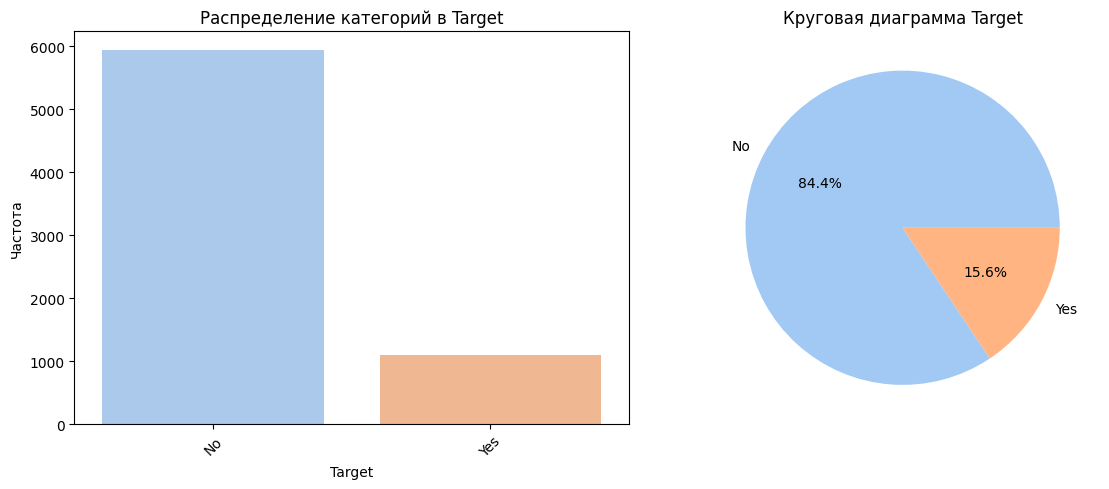

In [37]:
analyze_categorical_column(contract, 'Target')

**Вывод**: За 4 года ушло 15% пользователей. Есть дисбаланс классов, для целевого признака может быть критично.

### Анализ таблицы contract

#### Анализ столбца BeginDate

In [38]:
f"Временной промежуток данных: {contract['BeginDate'].min()} - {contract['BeginDate'].max()}"

'Временной промежуток данных: 2013-10-01 00:00:00 - 2020-02-01 00:00:00'

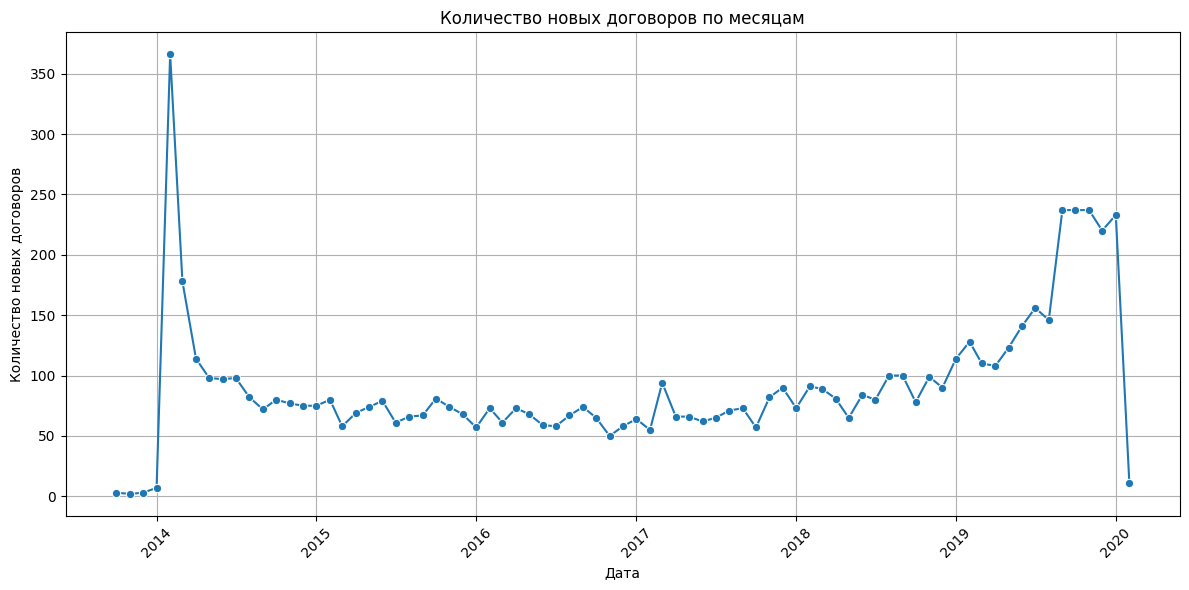

In [39]:
def contracts_time(df, date_column):
    df['YearMonth'] = df[date_column].dt.to_period('M').dt.to_timestamp()
    month = df.groupby('YearMonth').size()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=month.index, y=month.values, marker='o', linestyle='-')
    plt.title('Количество новых договоров по месяцам')
    plt.xlabel('Дата')
    plt.ylabel('Количество новых договоров')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    df.drop(columns=['YearMonth'], inplace=True)
contracts_time(contract, 'BeginDate')


In [40]:
def analyze_time_series(df, date_column, value_column):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df[date_column], y=df[value_column], marker='o', color='coral')
    plt.title(f'Временной ряд {value_column} по {date_column}')
    plt.xlabel(date_column)
    plt.ylabel(value_column)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


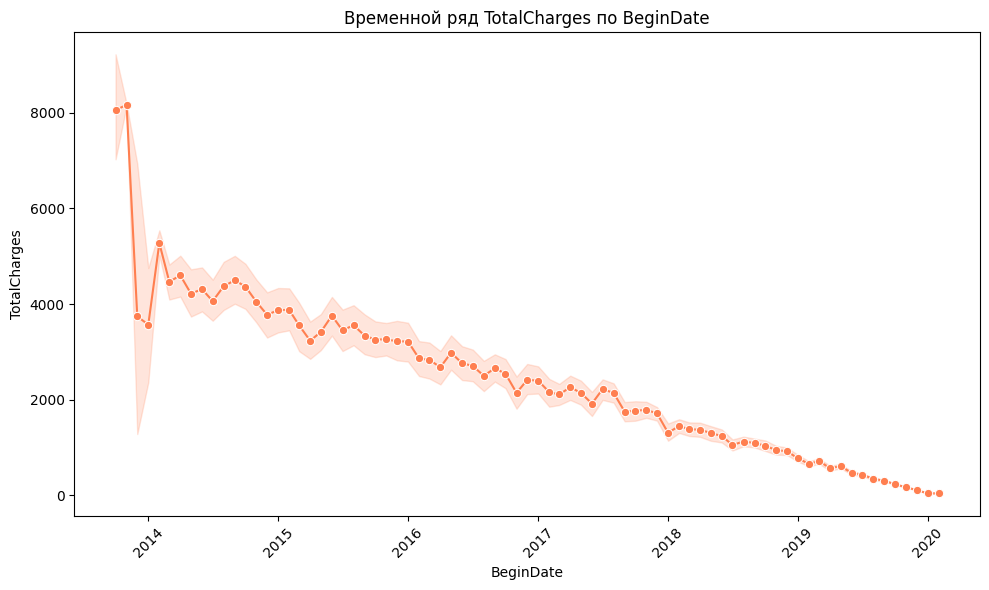

In [41]:
analyze_time_series(contract, 'BeginDate', 'TotalCharges')

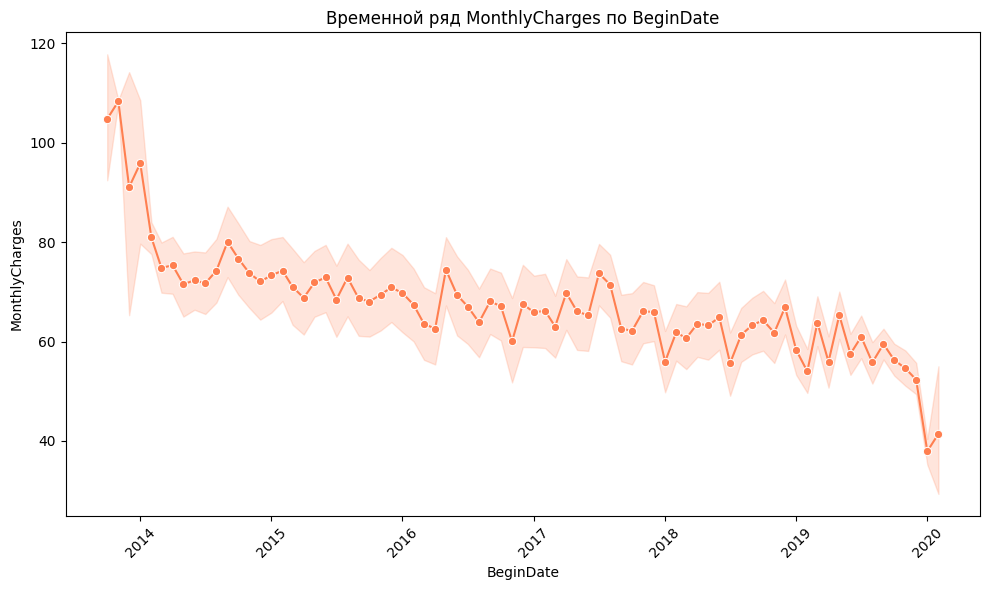

In [42]:
analyze_time_series(contract, 'BeginDate', 'MonthlyCharges')

**Вывод:** В результате анализа данного столбца и временых рядов для MonthlyCharges и TotalCharges, можно сделать вывод, что доход сокращается каждый год, но с начала 2019 года колличество новых договоров увеличивается.

#### Анализ столбца Type

In [43]:
contract['Type'].describe()

,Type
count,7043
unique,3
top,Month-to-month
freq,3875


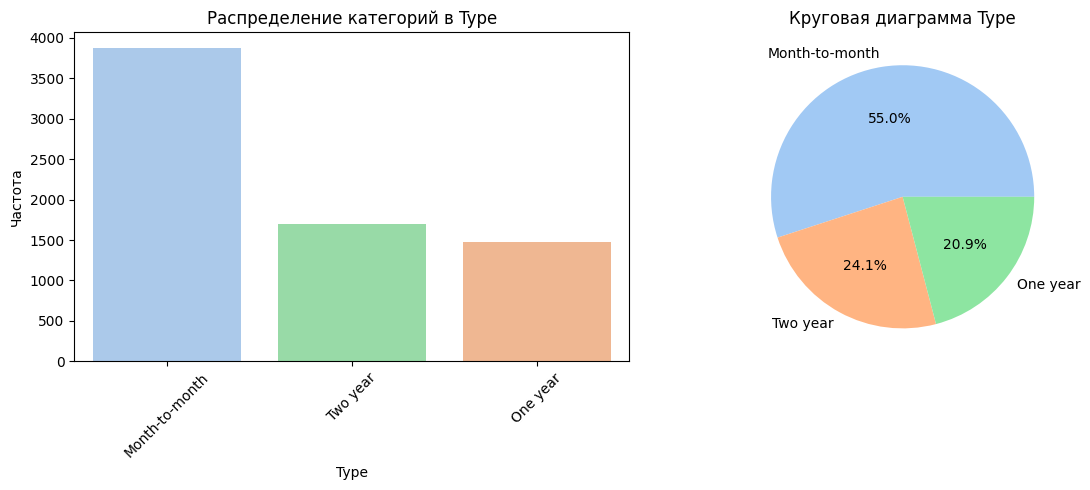

In [44]:
analyze_categorical_column(contract, 'Type')

**Вывод**: тип оплаты на графике раз в год-два или ежемесячно, существует дисбаланс классов, чаще всего оплата производится раз в месяц.

#### Анализ столбца PaperlessBilling

In [45]:
contract['PaperlessBilling'].describe()

,PaperlessBilling
count,7043
unique,2
top,Yes
freq,4171


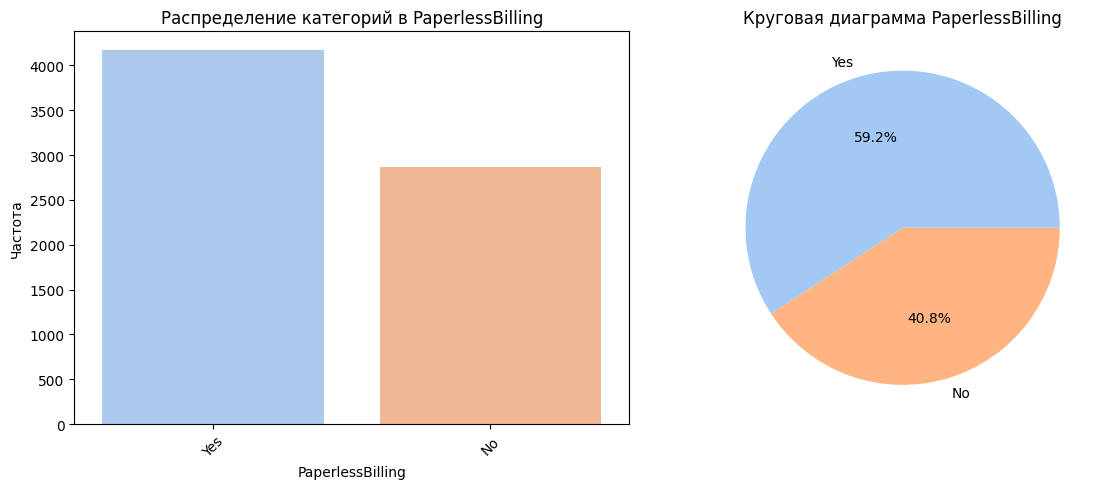

In [46]:
analyze_categorical_column(contract, 'PaperlessBilling')

**Вывод**: Больше половины пользователей осуществляют безналичный расчет.

#### Анализ столбца PaymentMethod

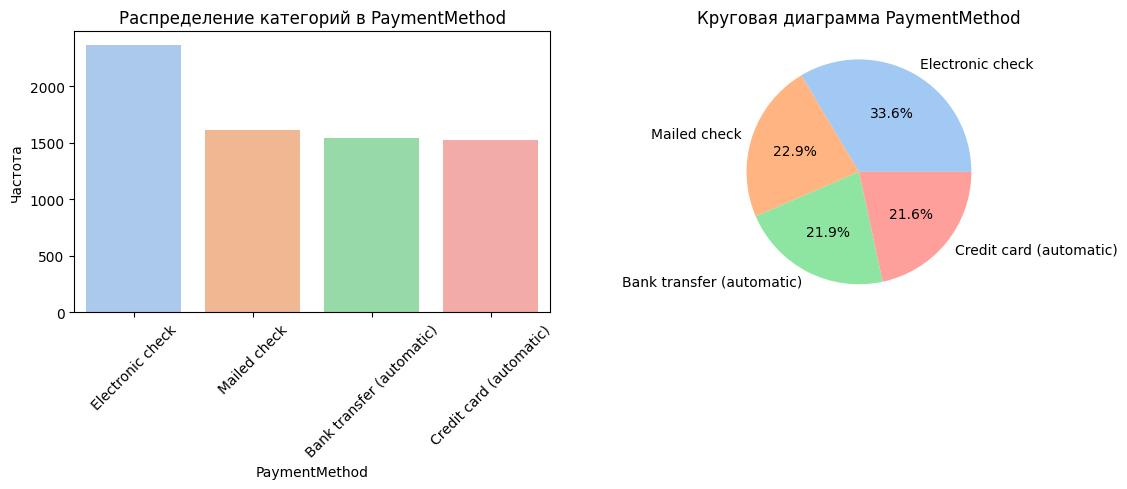

In [47]:
analyze_categorical_column(contract, 'PaymentMethod')

#### Анализ столбца MonthlyCharges

In [48]:
def analyze_numeric_column(df, column_name, bins='auto'):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name].dropna(), kde=True, color='#F08080', bins=bins)
    plt.title(f'Гистограмма {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column_name], color='#20B2AA')
    plt.title(f'Boxplot {column_name}')
    plt.xlabel(column_name)

    plt.tight_layout()
    plt.show()

In [49]:
contract['MonthlyCharges'].describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


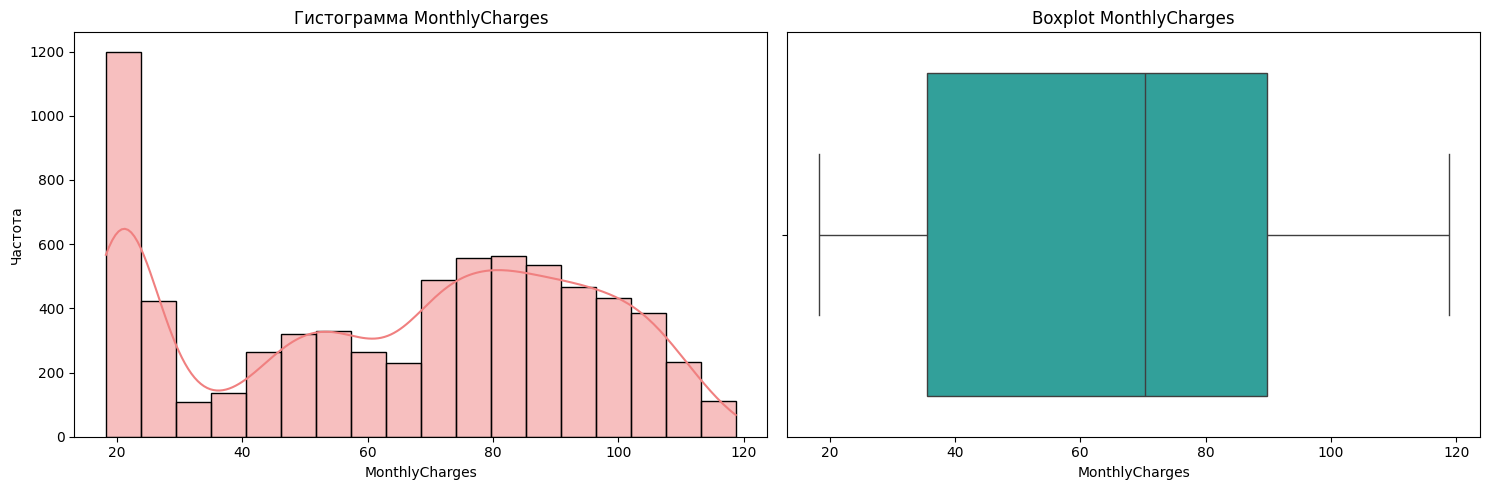

In [50]:
analyze_numeric_column(contract, 'MonthlyCharges')

**Вывод**: Пик расположен на 20, когда минимальные расходы за месяц - 18. Медианые расходы - 64.  

#### Анализ столбца TotalCharges

In [51]:
contract['TotalCharges'].describe()

,TotalCharges
count,7043.000000
mean,2115.377573
std,2112.678861
min,19.050000
25%,436.750000
50%,1343.350000
75%,3236.690000
max,9221.380000


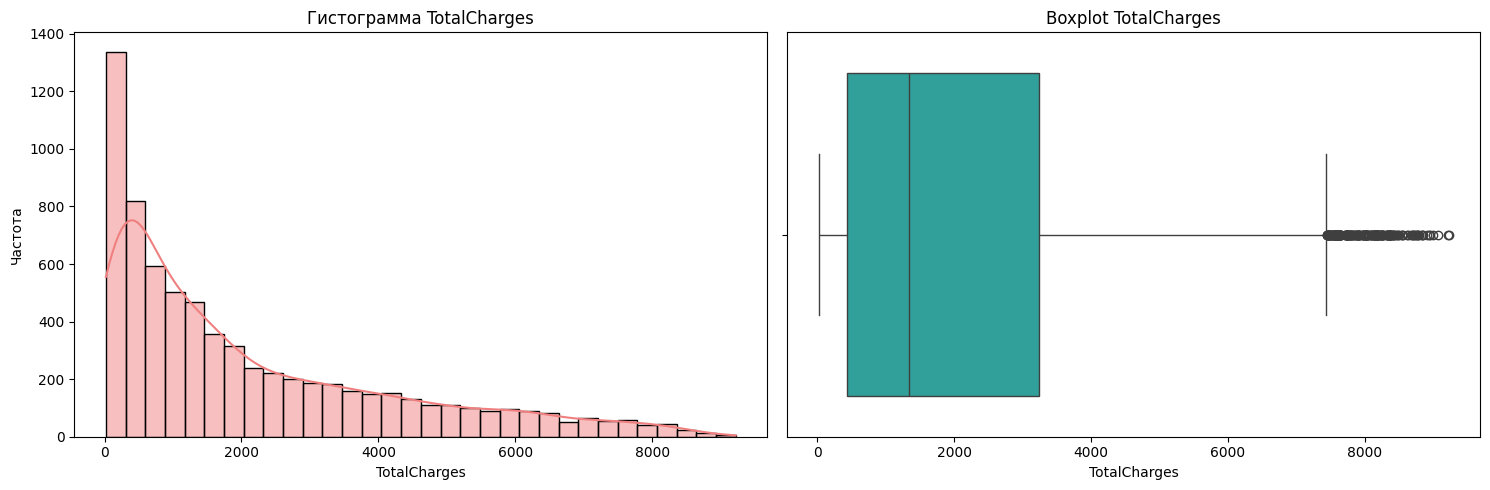

In [52]:
analyze_numeric_column(contract, 'TotalCharges')

**Вывод**: Общие расходы абонента сильно смещены влево, и имеют длинный хвост, в данном случае медиана равна 2115, а пик расположен на минимальных расходах.

### Анализ таблицы personal

#### Анализ столбца gender

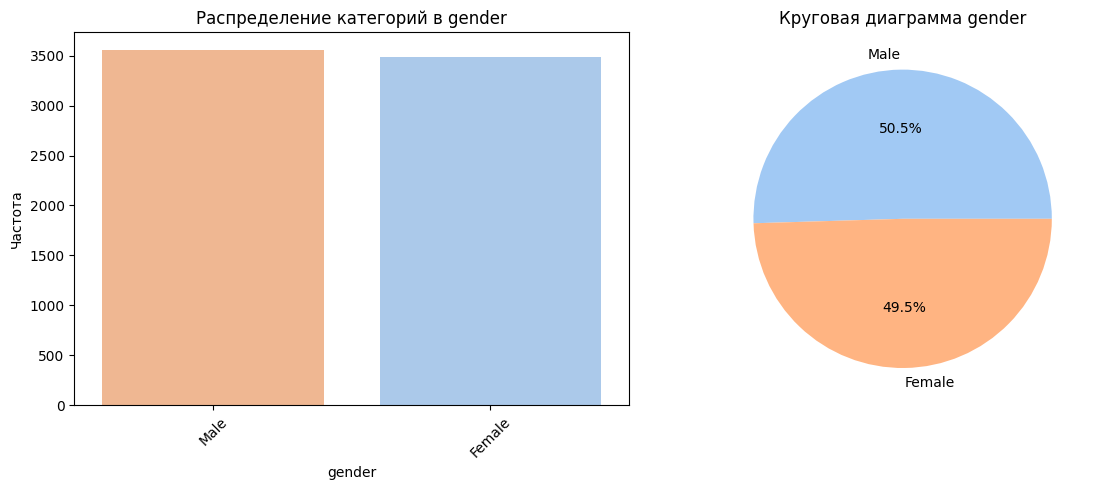

In [53]:
analyze_categorical_column(personal, 'gender')

**Вывод**: Пол распределен равномерно.

#### Анализ столбца SeniorCitizen

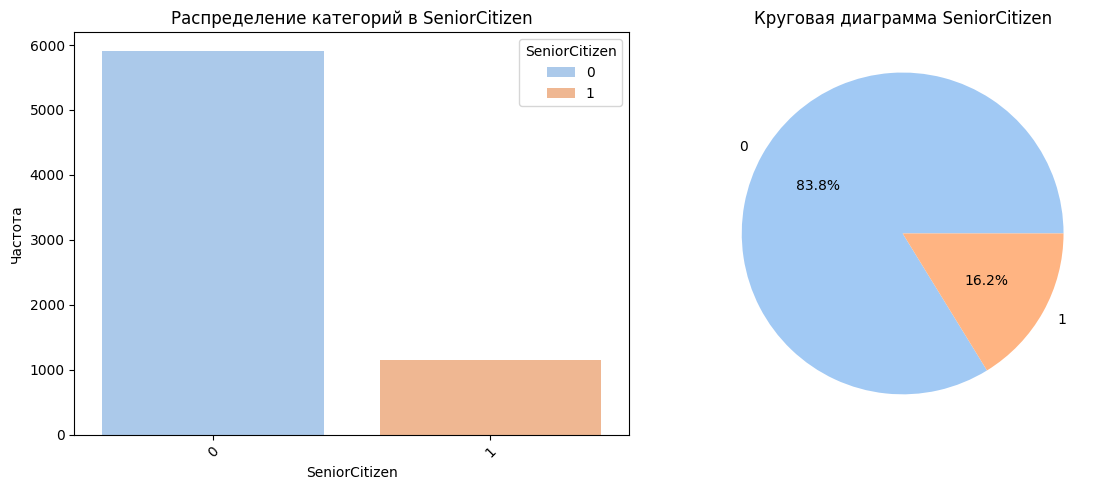

In [54]:
analyze_categorical_column(personal, 'SeniorCitizen')

**Вывод**: Из всех пользователей пенсионеры представляют 16%.

#### Анализ столбца Partner

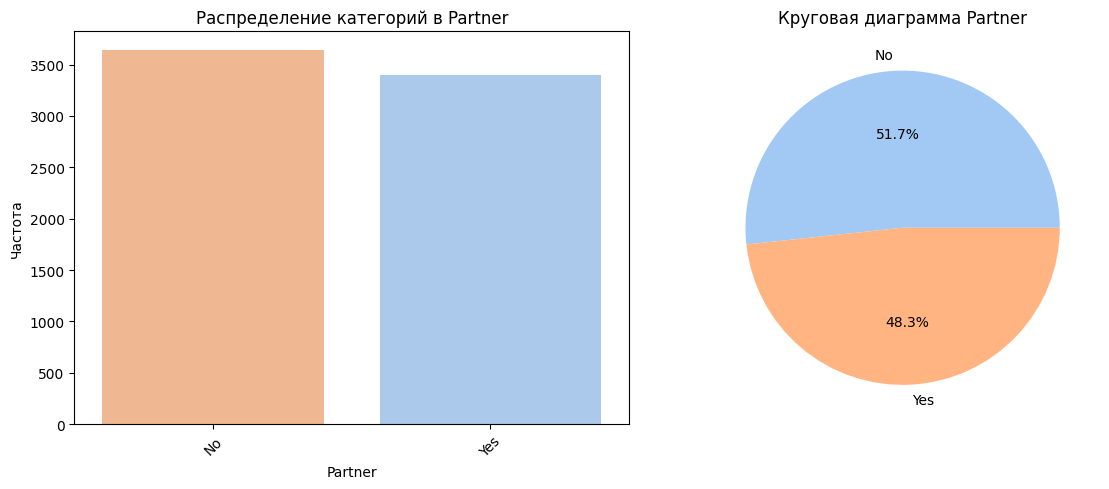

In [55]:
analyze_categorical_column(personal, 'Partner')

**Вывод**: Наличие партнера в данном столбце распределено равномерно, в категории 'Yes' немного меньше пользователей - 48.3%

#### Анализ столбца Dependents

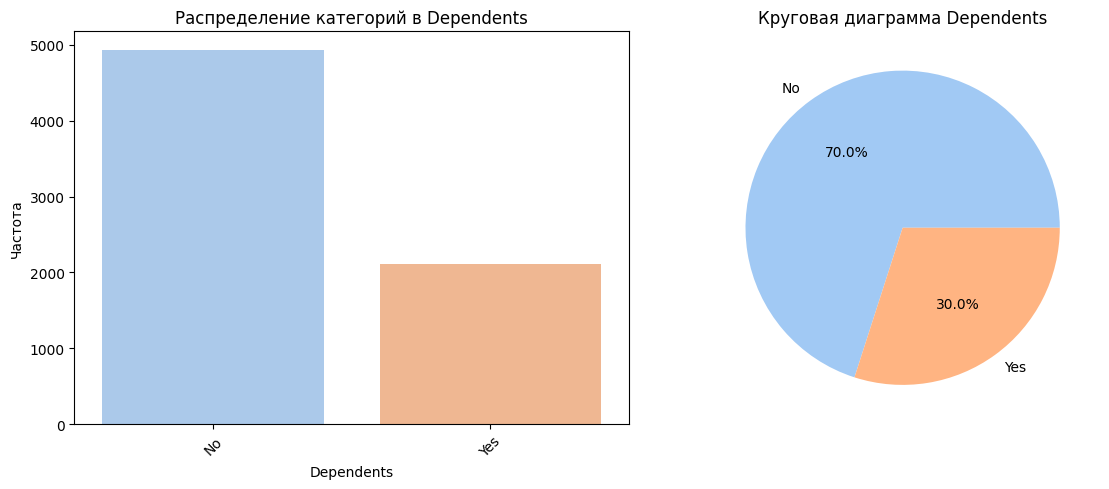

In [56]:
analyze_categorical_column(personal, 'Dependents')

**Вывод**: Пользователи с без детей сотавляют большую часть - 70%.

### Анализ таблицы internet

#### Анализ столбца InternetService

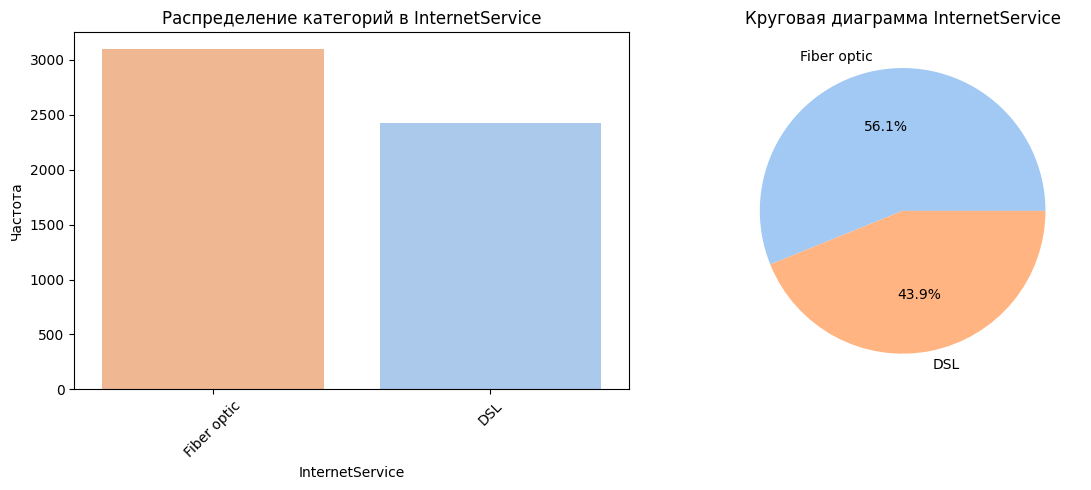

In [57]:
analyze_categorical_column(internet, 'InternetService')

**Вывод**: Большенство пользователей подключены через оптоволоконный кабель.

#### Анализ столбца OnlineSecurity

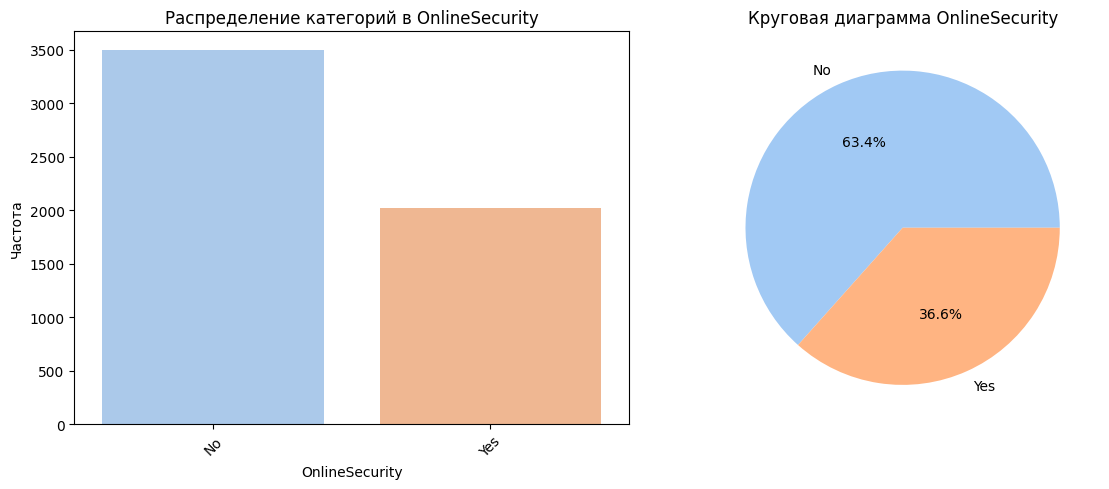

In [58]:
analyze_categorical_column(internet, 'OnlineSecurity')

**Вывод**: Большинство пользователей не используют блокировку опасных сайтов .

#### Анализ столбца OnlineBackup

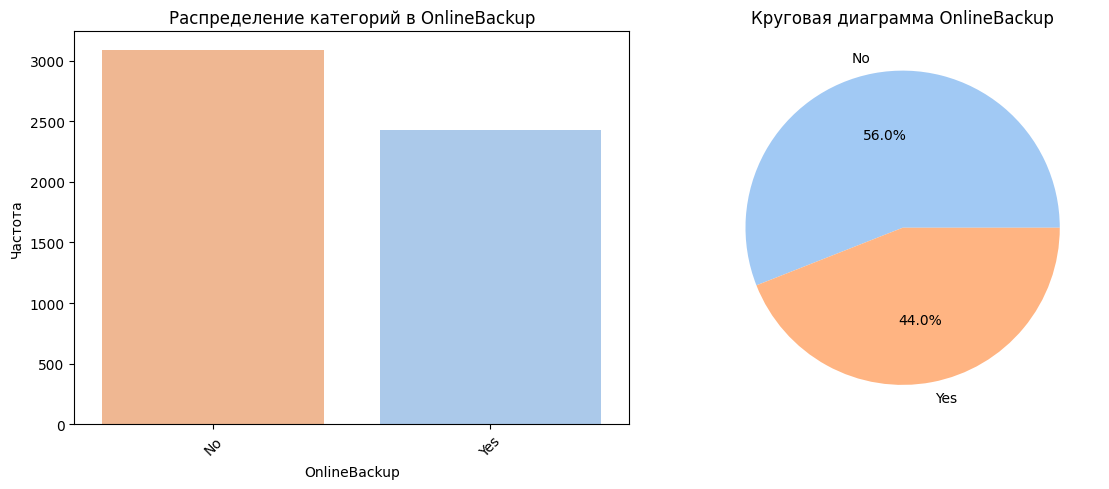

In [59]:
analyze_categorical_column(internet, 'OnlineBackup')

**Вывод**: Большинство пользователей не используют облачное хранилище, но разница не большая, пользоватлей без облачного хранилища - 44%

#### Анализ столбца DeviceProtection

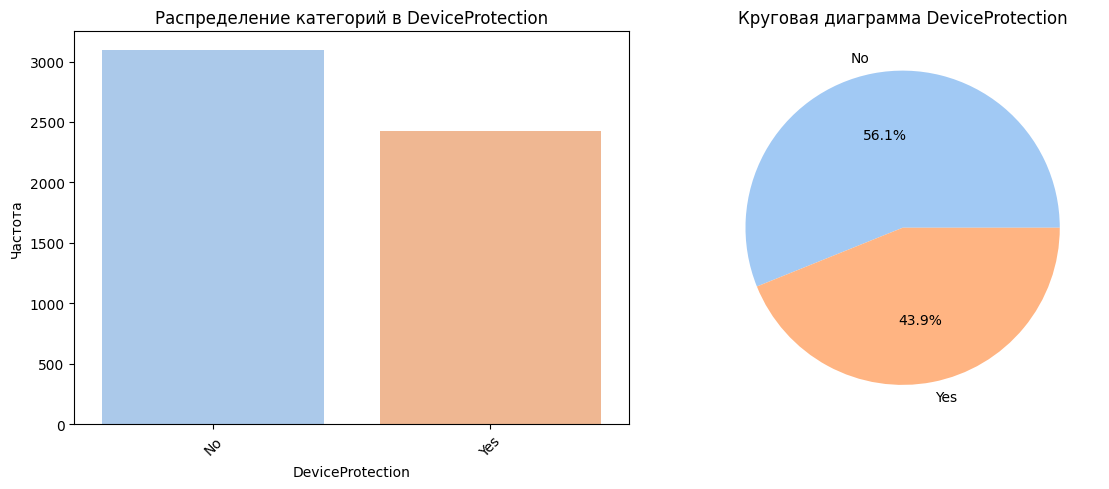

In [60]:
analyze_categorical_column(internet, 'DeviceProtection')

**Вывод**: Большинство пользователей (56%) не используют антивирус.

#### Анализ столбца TechSupport

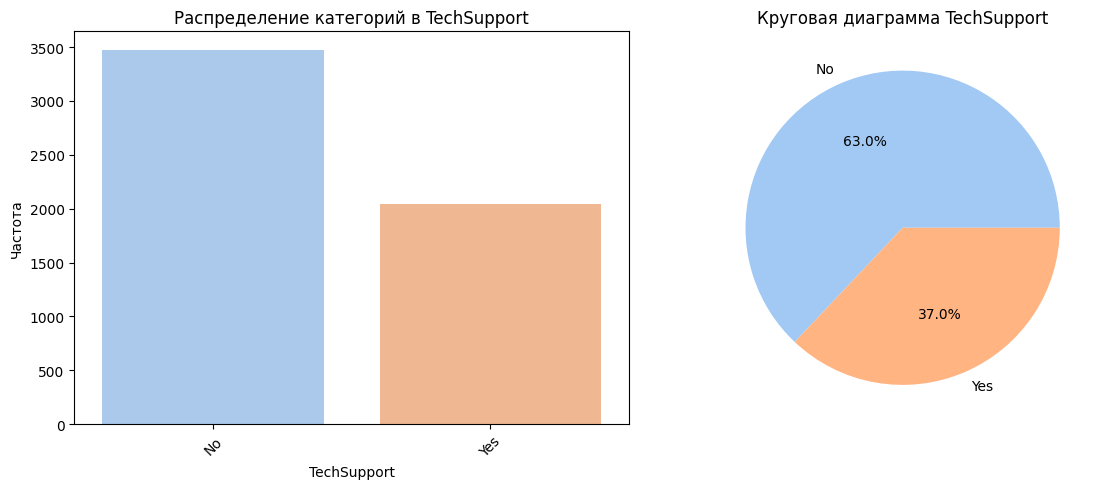

In [61]:
analyze_categorical_column(internet, 'TechSupport')

**Вывод**: Большинство пользователей (63%) не используют линию технической поддержки.

#### Анализ столбца StreamingTV

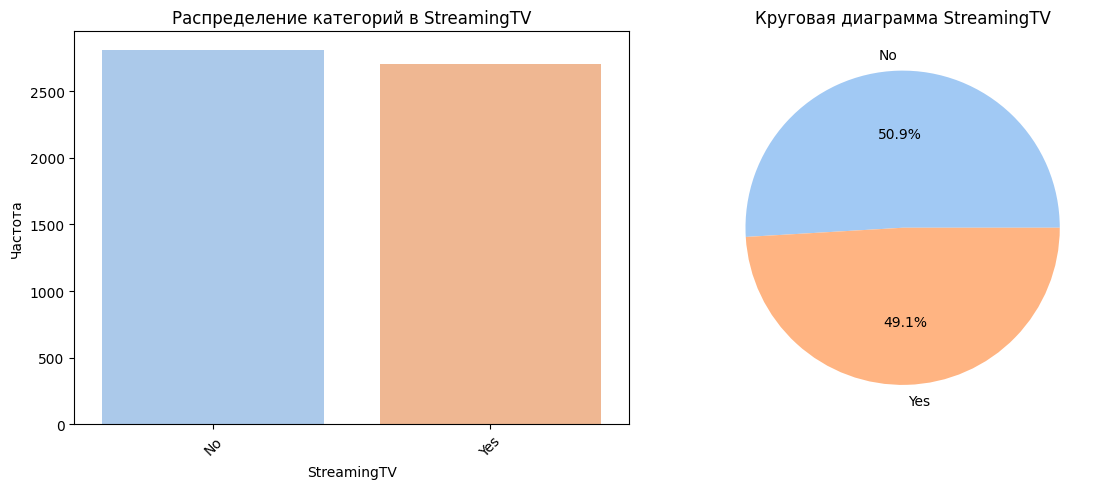

In [62]:
analyze_categorical_column(internet, 'StreamingTV')

**Вывод**: Пользователи в данном столбце распределены равномерно.

#### Анализ столбца StreamingMovies

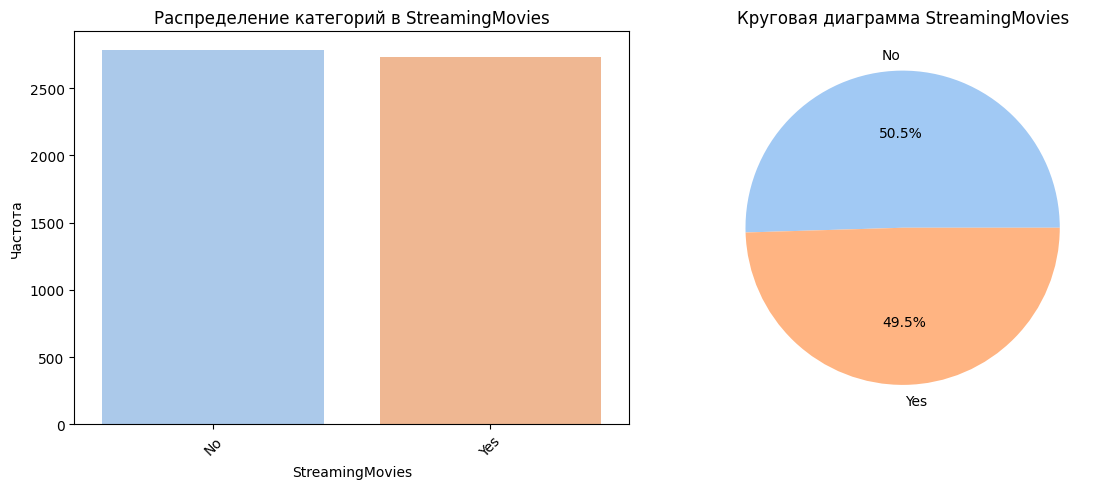

In [63]:
analyze_categorical_column(internet, 'StreamingMovies')

**Вывод**: Пользователи в данном столбце распределены равномерно.

### Анализ таблицы phone, столбца MultipleLines

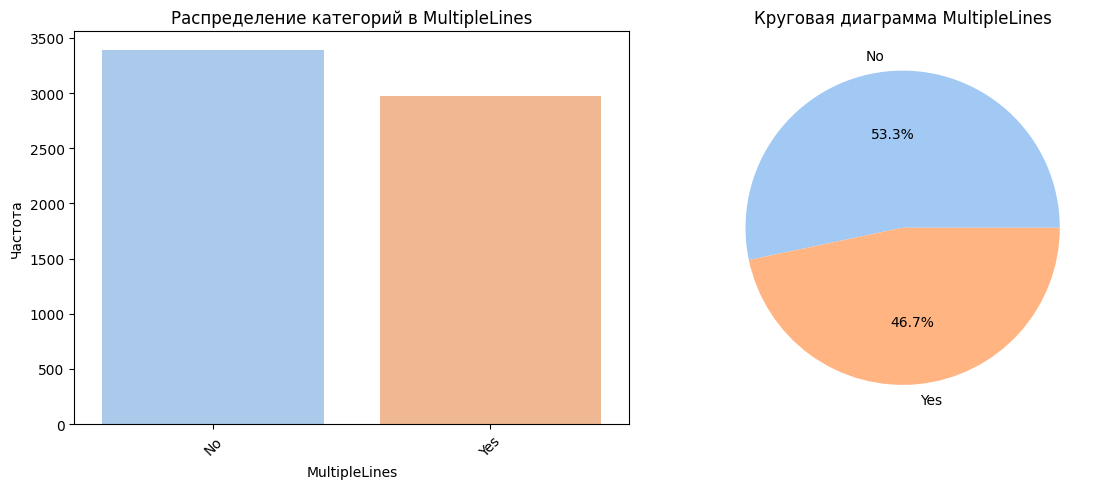

In [64]:
analyze_categorical_column(phone, 'MultipleLines')

**Вывод**: Пользователи в данном столбце распределены равномерно.

**Вывод об исследовательском анализе данных:**
Анализ данных выявил несколько ключевых тенденций, включая сокращение доходов компании с одновременным увеличением количества новых договоров с 2019 года. Большинство клиентов предпочитают ежемесячную оплату и безналичный расчет, а также подключены через оптоволоконный кабель. Важно отметить, что значительная часть пользователей не используют дополнительные услуги, такие как блокировка опасных сайтов, облачные хранилища, антивирусные программы и техническую поддержку.

##Объединение данных в общую таблицу

In [65]:
print(f"Размерность таблицы contract: {contract.shape}")
print(f"Размерность таблицы personal: {personal.shape}")
data = pd.merge(contract, personal, on='customerID', how='outer')
print(f"Размерность таблицы data после объединения contract и personal: {data.shape}")

print(f"Размерность таблицы internet: {internet.shape}")
data = pd.merge(data, internet, on='customerID', how='outer')
print(f"Размерность таблицы data после добавления internet: {data.shape}")

print(f"Размерность таблицы phone: {phone.shape}")
data = pd.merge(data, phone, on='customerID', how='outer')
print(f"Размерность таблицы data после добавления phone: {data.shape}")

data.info()

Размерность таблицы contract: (7043, 9)
Размерность таблицы personal: (7043, 5)
Размерность таблицы data после объединения contract и personal: (7043, 13)
Размерность таблицы internet: (5517, 8)
Размерность таблицы data после добавления internet: (7043, 20)
Размерность таблицы phone: (6361, 2)
Размерность таблицы data после добавления phone: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64      

### Проверка и обработка пропусков.
В столбцах: InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, и MultipleLines обнаружены пропуски. Если пользователь отсутствует в таблицах internet или phone, это означает, что он не использует соответствующую услугу. Для таких категориальных признаков можем создать новую категорию 'Not used', чтобы отразить отсутствие использования данных услуг.

In [66]:
columns_to_fill = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines'
]
data[columns_to_fill] = data[columns_to_fill].fillna('Not used')
data[columns_to_fill].isnull().sum()

,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0
DeviceProtection,0
TechSupport,0
StreamingTV,0
StreamingMovies,0
MultipleLines,0


## Исследовательский анализ данных объедененной таблицы.

### Создание новых признаков.

In [67]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], errors='coerce')
data['EndDate_temp'] = data['EndDate'].replace('No', '2020-02-01')
data['EndDate_temp'] = pd.to_datetime(data['EndDate_temp'], errors='coerce')

def calculate_days(row):
    end_date = row['EndDate_temp']
    return (end_date - row['BeginDate']).days

data['DaysUsed'] = data.apply(calculate_days, axis=1)
data.drop(columns=['EndDate_temp'], inplace=True)
data[['BeginDate', 'EndDate', 'DaysUsed']].head()

,BeginDate,EndDate,DaysUsed
0,2019-05-01,No,276
1,2019-05-01,No,276
2,2019-09-01,No,153
3,2018-12-01,No,427
4,2019-09-01,No,153


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   object        
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

Данный признак отражает количество дней, которые пользователь был клиентом оператора связи ТелеДом. Далее мы проанализируем количественные признаки по группам целевого признака. В нашем случае ограниченное количество пользователей с оконченными договорами затрудняет качественный анализ, поскольку выборка для этой группы является небольшой.

### Дополнительный анализ количественных признаков

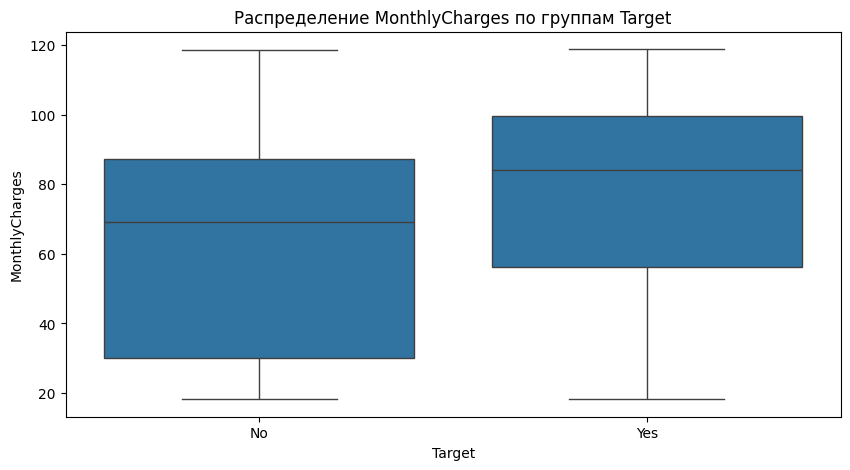

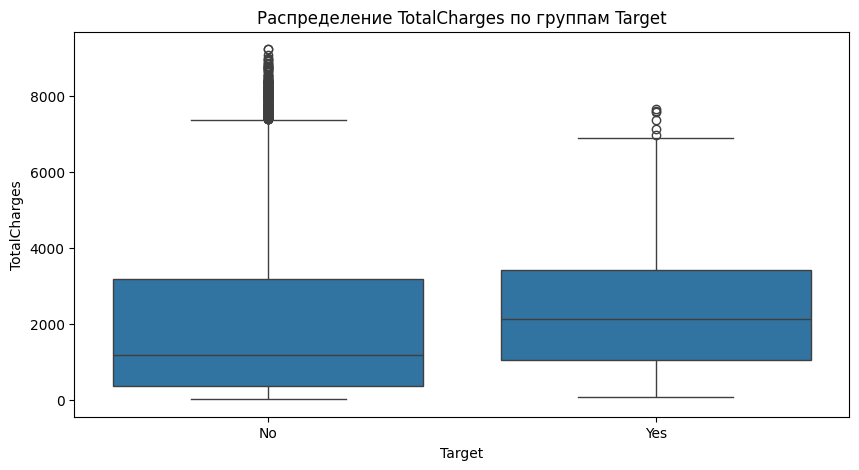

In [69]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Target', y='MonthlyCharges', data=data)
plt.title('Распределение MonthlyCharges по группам Target')
plt.xlabel('Target')
plt.ylabel('MonthlyCharges')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='Target', y='TotalCharges', data=data)
plt.title('Распределение TotalCharges по группам Target')
plt.xlabel('Target')
plt.ylabel('TotalCharges')
plt.show()

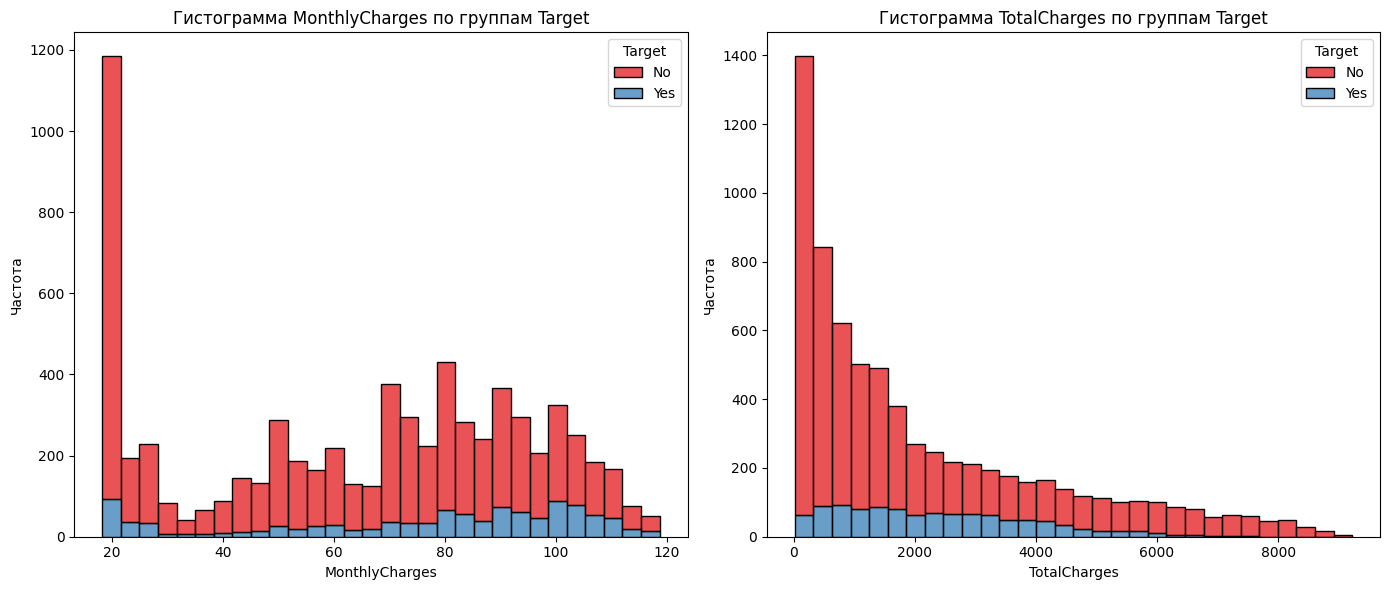

In [70]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='MonthlyCharges', hue='Target', multiple='stack', palette='Set1', bins=30)
plt.title('Гистограмма MonthlyCharges по группам Target')
plt.xlabel('MonthlyCharges')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='TotalCharges', hue='Target', multiple='stack', palette='Set1', bins=30)
plt.title('Гистограмма TotalCharges по группам Target')
plt.xlabel('TotalCharges')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

**Вывод**: В столбце TotalCharges разброс значений у пользователей с оконченным договором ('Yes') меньше, что указывает на меньшее количество экстремальных значений. Напротив, у пользователей с неоконченным договором ('No') наблюдается больше выбросов. Это может быть связано с тем, что значения TotalChargesимеют смещение влево, что означает, что много значений сосредоточено в нижнем диапазоне.
Более четкое различие между группами демонстрирует столбец MonthlyCharges. В этом столбце разброс значений меньше, что позволяет сделать вывод о том, что дисперсия выше в группе с неоконченным договором ('No'). Поэтому MonthlyCharges является более надежным показателем для анализа различий между группами.

In [71]:
data['DaysUsed'].describe()

,DaysUsed
count,7043.000000
mean,898.555729
std,683.130510
min,0.000000
25%,276.000000
50%,761.000000
75%,1461.000000
max,2314.000000


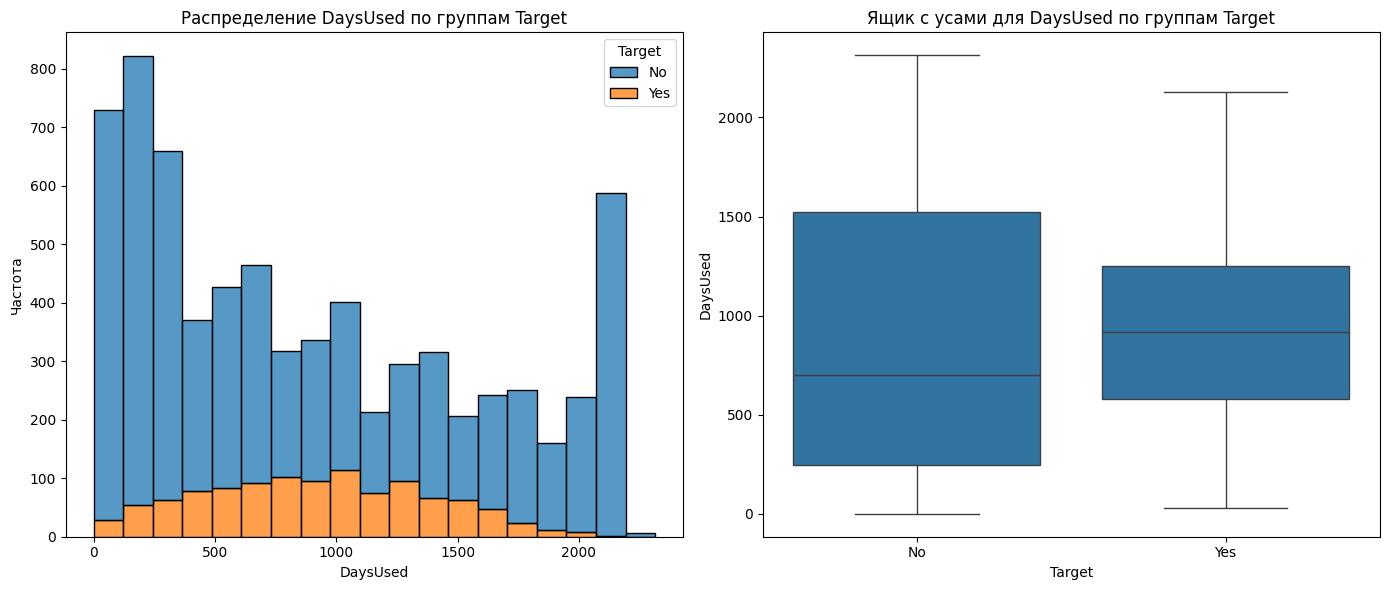

In [72]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=data, x='DaysUsed', hue='Target', multiple='stack')
plt.title('Распределение DaysUsed по группам Target')
plt.xlabel('DaysUsed')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x='Target', y='DaysUsed', data=data)
plt.title('Ящик с усами для DaysUsed по группам Target')
plt.xlabel('Target')
plt.ylabel('DaysUsed')

plt.tight_layout()
plt.show()

**Вывод**: Количество дней использования для группы с оконченным договором близко к нормальному распределению. Это указывает на то, что большинство пользователей этой группы использовали платформу примерно одинаковое количество времени, с небольшой вариацией.

В то время как для группы с неоконченными договорами наблюдается другой шаблон распределения. Здесь явный пик на 300 днях, что может указывать на то, что большинство пользователей с активными договорами недавно начали использовать платформу. Нулевые значения могут означать, что договор был расторгнут в день его создания или что данные были выгружены непосредственно в день создания договора.

Медиана количества дней использования в группе с неоконченными договорами расположена на уровне 761 дня. Это может свидетельствовать о большом разнообразии в длительности использования платформы среди пользователей с активными договорами.

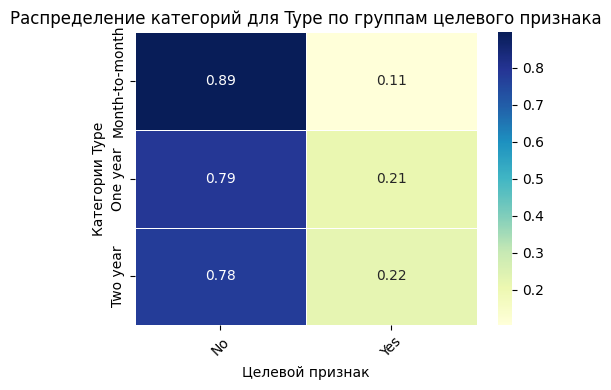

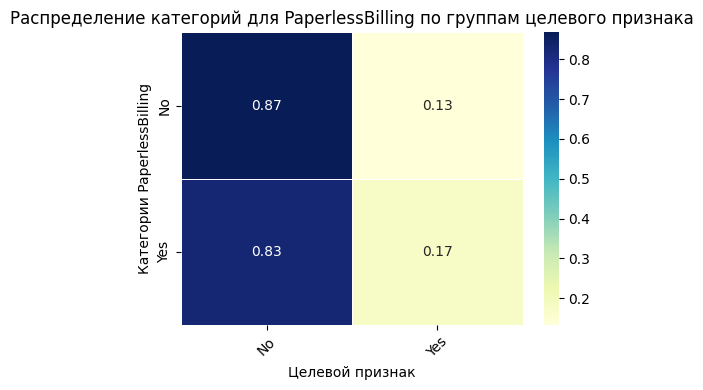

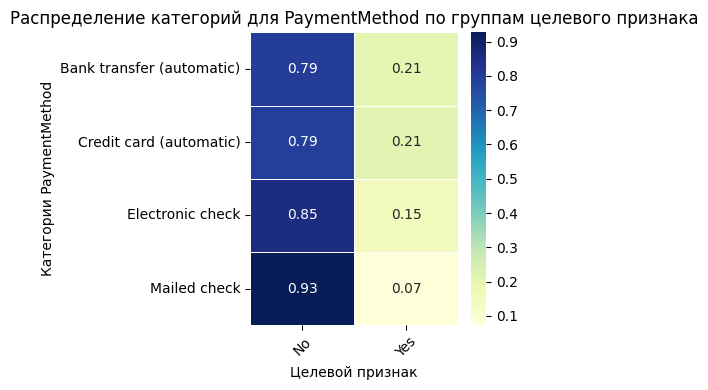

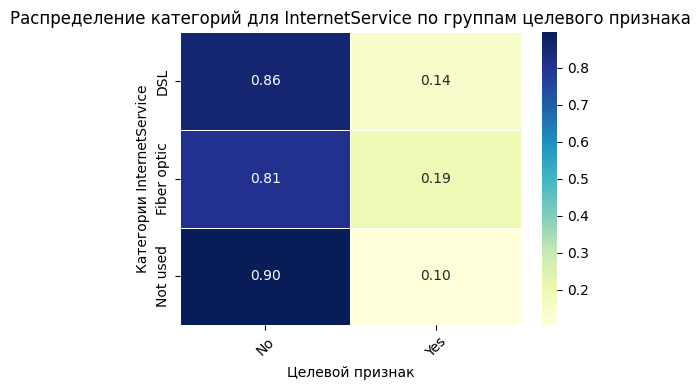

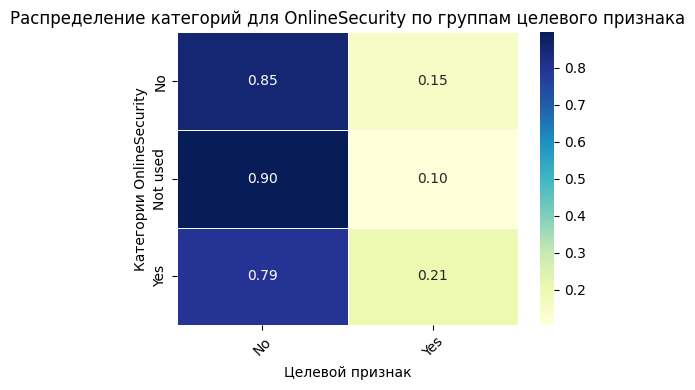

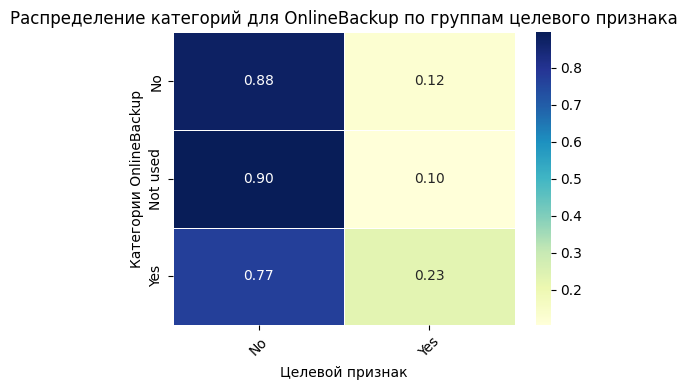

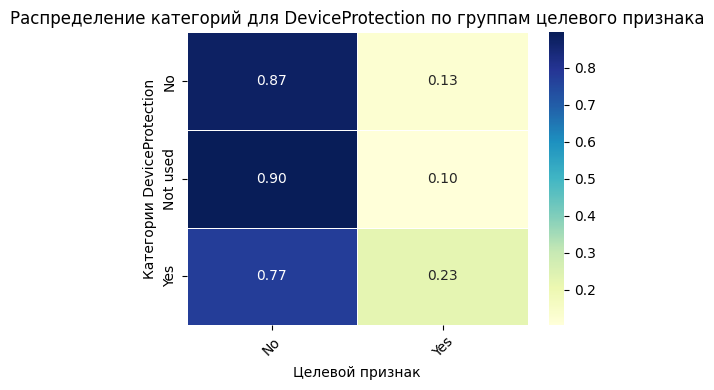

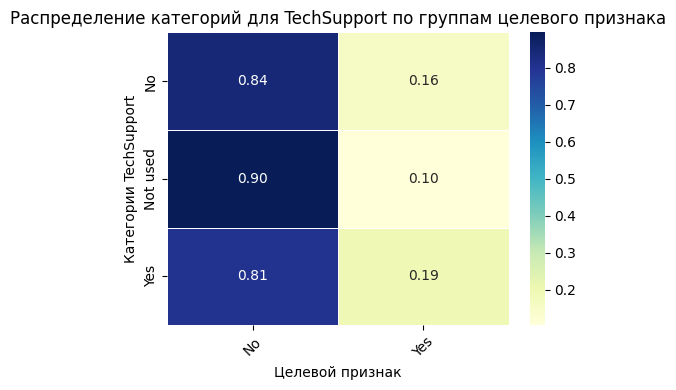

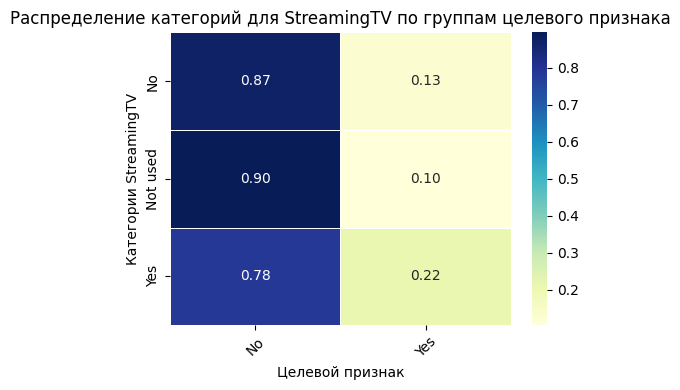

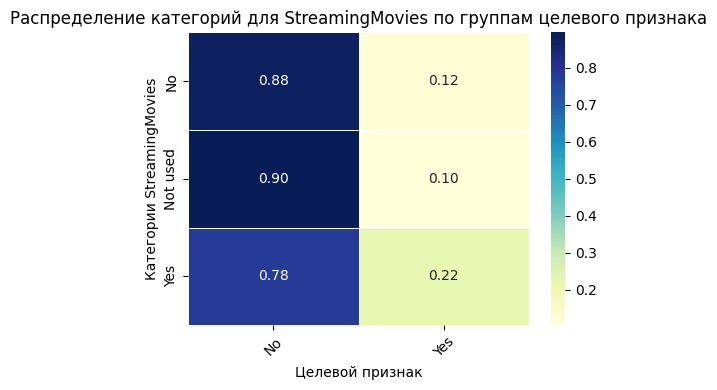

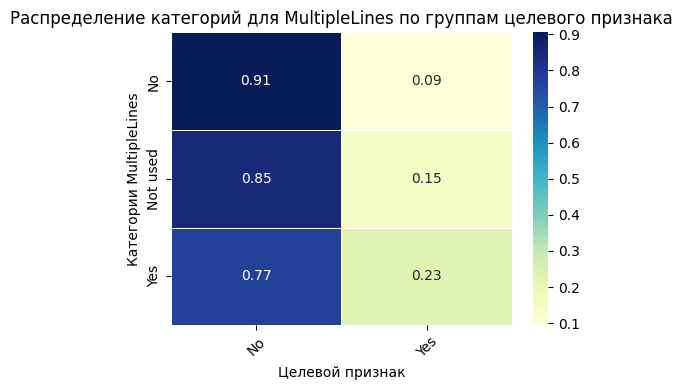

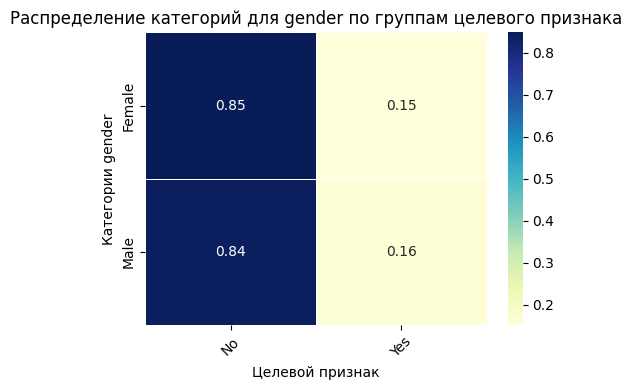

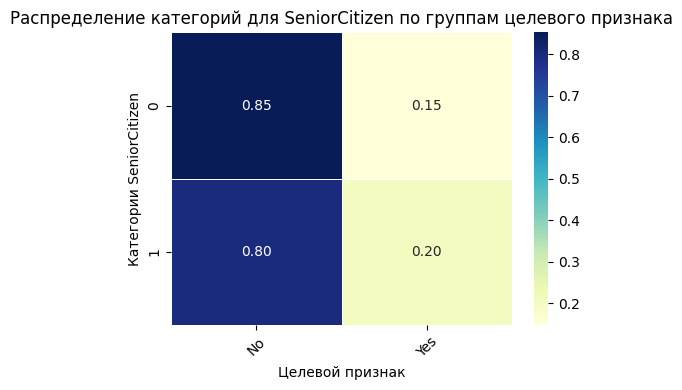

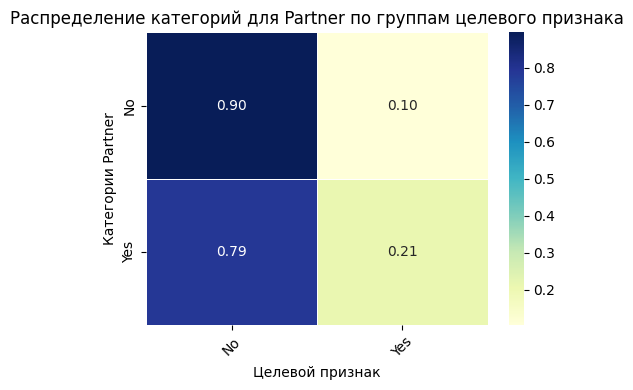

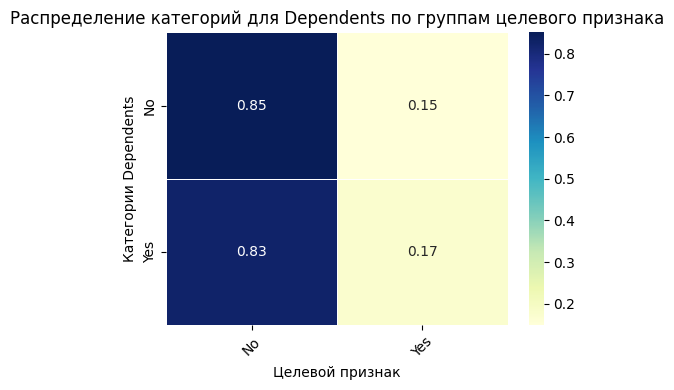

In [73]:
categorical_columns = [
    'Type', 'PaperlessBilling', 'PaymentMethod',
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines', 'gender',
    'SeniorCitizen', 'Partner', 'Dependents'
]
for column in categorical_columns:
    distribution = pd.crosstab(data[column], data['Target'])
    distribution = distribution.div(distribution.sum(axis=1), axis=0)

    plt.figure(figsize=(5, 4))
    sns.heatmap(distribution, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
    plt.title(f'Распределение категорий для {column} по группам целевого признака')
    plt.xlabel('Целевой признак')
    plt.ylabel(f'Категории {column}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Вывод**: Проанализировав распределение категориальных признаков по группам целевого признака, можно сделать следующие выводы:

1. Преобладание группы "No": Во всех анализируемых признаках преобладает категория "No". Это также отражает общий тренд среди пользователей, где большинство данных относят к группе "No".

2. Аномальные значения: Некоторые признаки показывают значительные аномалии. Например, в столбце PaymentMethod категория Mailed check составляет только около 7% для группы "Yes". Это довольно низкий показатель по сравнению с другими методами оплаты. Подобная ситуация наблюдается и в столбце MultipleLines, где только 9% пользователей из группы (Yes) с подключённым телефоном имеют статус No по признаку MultipleLines.

3. Распределение целевого признака: В большинстве случаев распределение групп целевого признака близко к соотношению 80% к 20% или 90% к 10%. Это говорит о том, что в данных присутствует явное несоответствие классов, где одна группа значительно преобладает над другой.


Поскольку в нашем случае существует проблема дисбаланса классов, желательно использовать семплирование данных, а так же по этому стоит использовать именно метрику AUC-ROC, он подходит для несбалансированных классов в задачах классификации.

### Анализ корреляций.

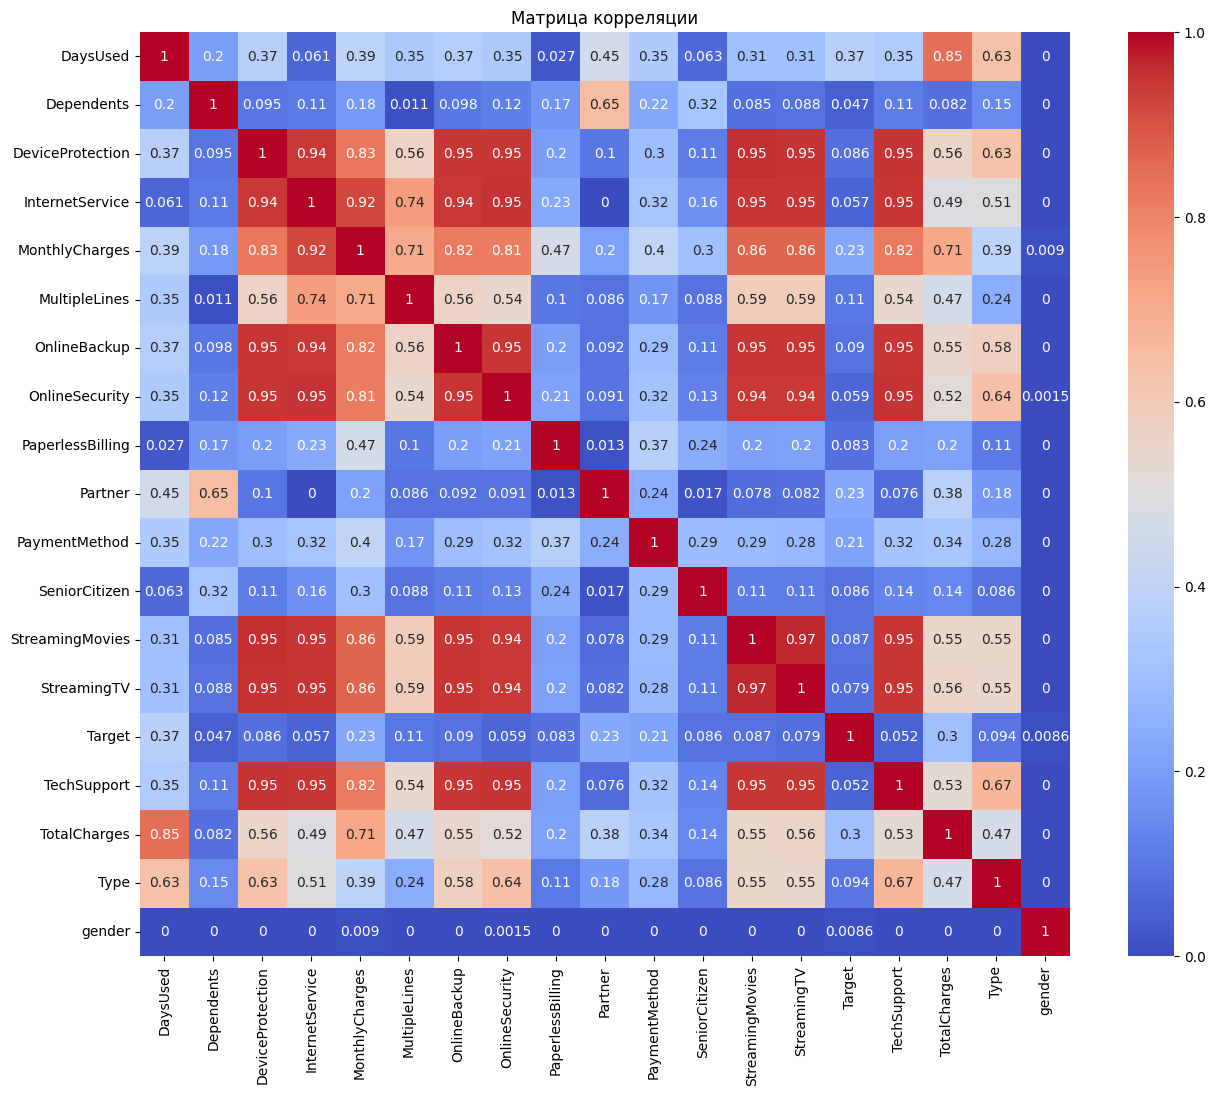

In [74]:
columns_list = data.columns.difference(['customerID', 'BeginDate', 'EndDate'])

correlation_matrix = data[columns_list].phik_matrix(
    interval_cols=['TotalCharges','MonthlyCharges','DaysUsed'])


plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

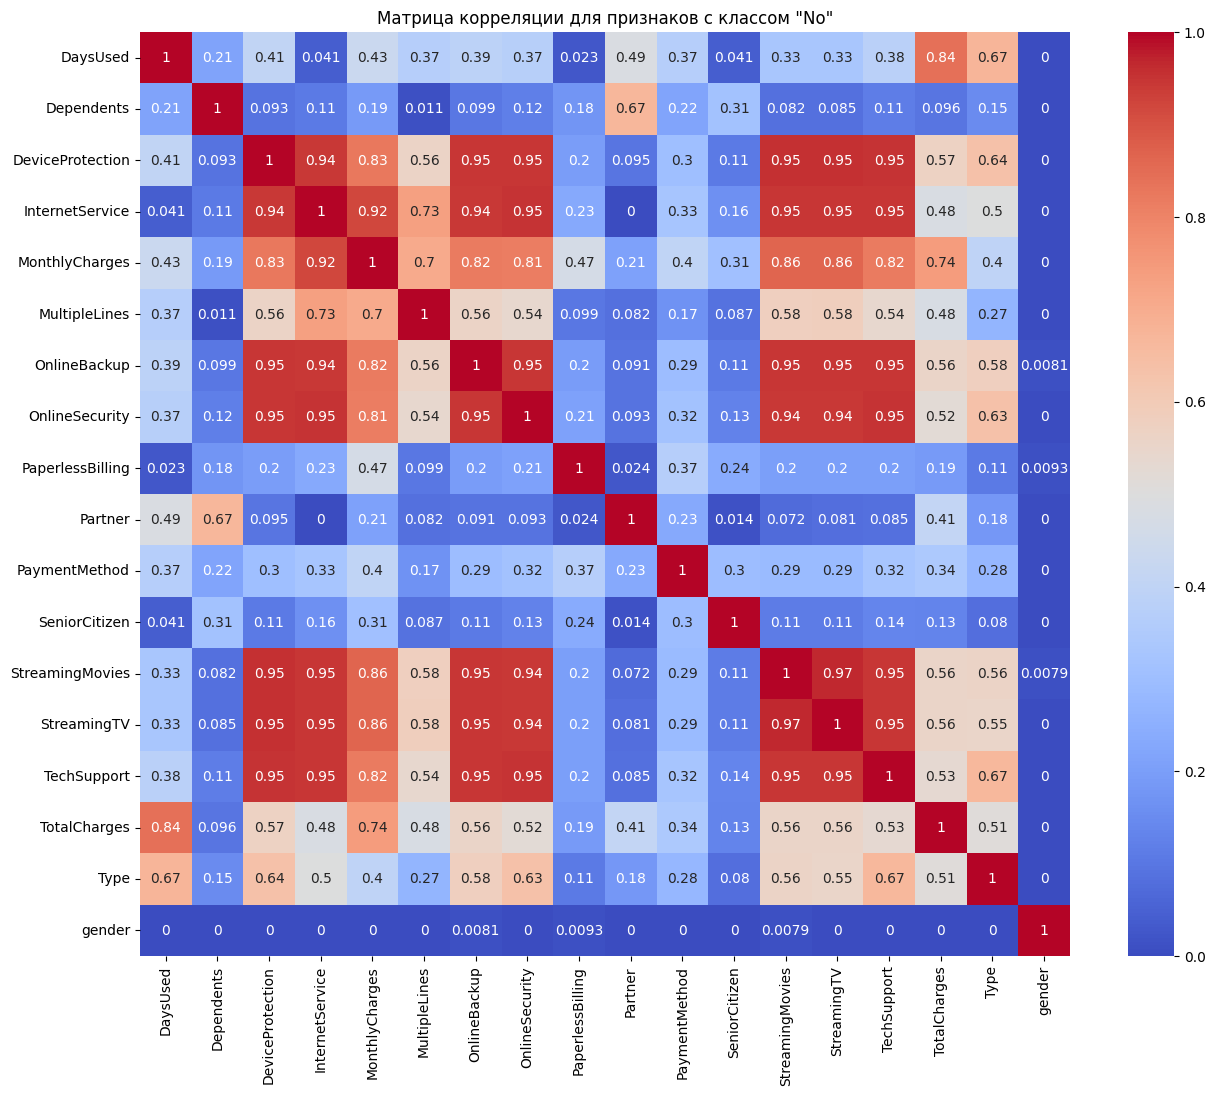

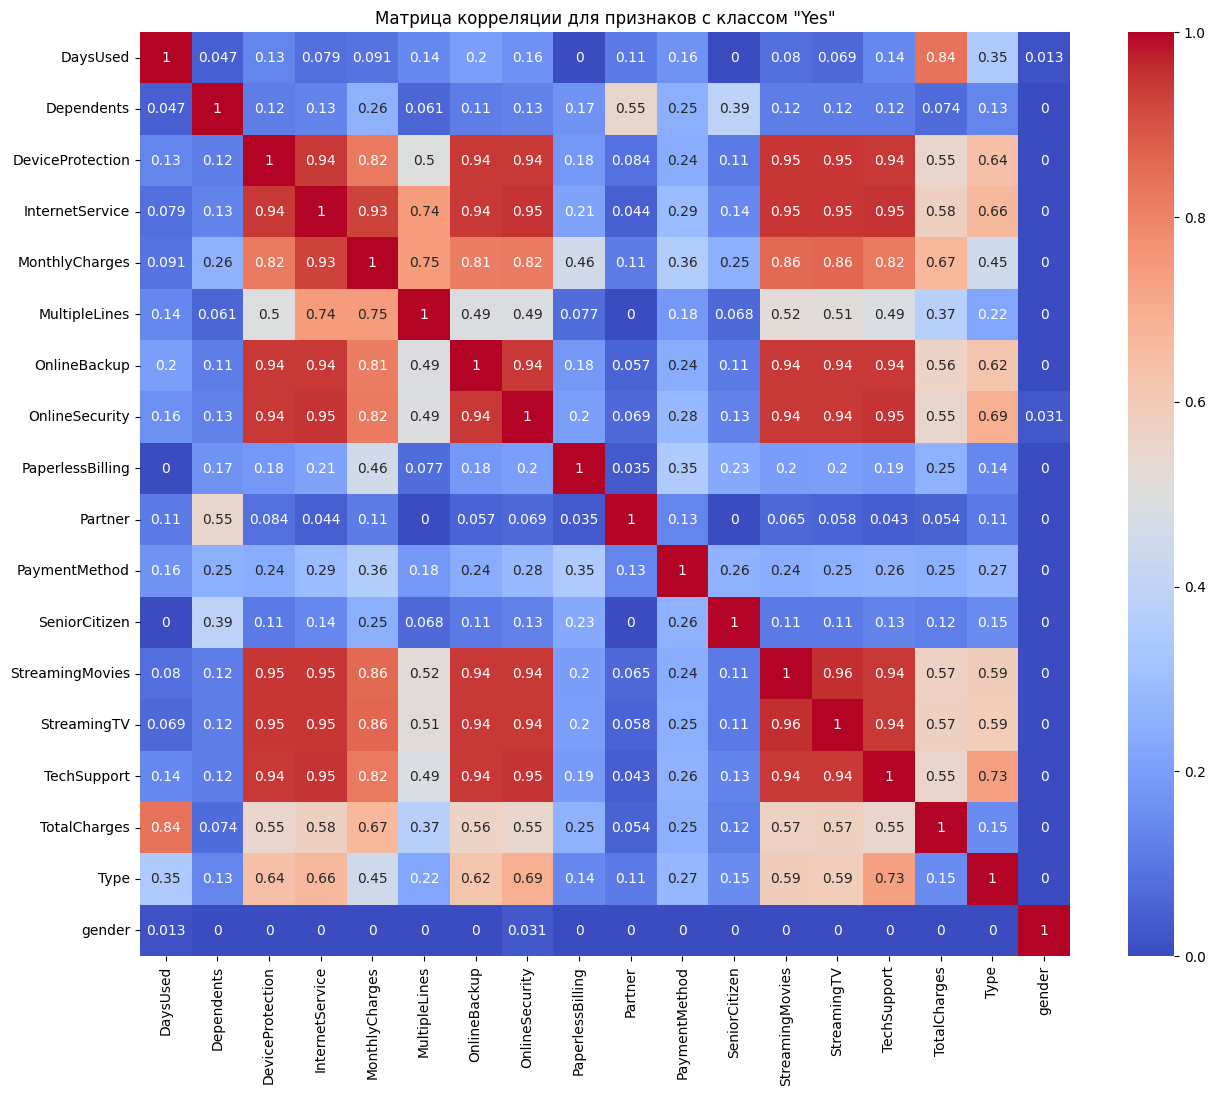

In [75]:
groups = data.groupby('Target')

for cls, group_data in groups:
    correlation_matrix = group_data[columns_list].phik_matrix(
    interval_cols=['TotalCharges','MonthlyCharges','DaysUsed'])

    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Матрица корреляции для признаков с классом "{cls}"')
    plt.show()

**Вывод о корреляции признаков**
Из анализа корреляции признаков следует, что:
1. Признак "Gender" не имеет значительной корреляции с другими признаками, что указывает на его низкую значимость в данном контексте.

2. Целевой признак ("Target") также показывает низкую корреляцию с большинством других признаков. Наибольшая корреляция наблюдается с признаком "DaysUsed" . Корреляция с "TotalCharges" составляет 0.23, а с "MonthlyCharges" — 0.3.

3. Многие признаки демонстрируют высокую взаимную корреляцию, что может указывать на проблему мультиколлинеарности. Это может привести к проблемам с линейными моделями.

4. Признаки "TotalCharges"  и "Type"  хорошо коррелируют с "DaysUsed". Это может быть связано с тем, что пользователи, подключающие одну дополнительную услугу, часто также используют и другие услуги, или же это может зависеть от предлагаемых компанией пакетов.

## Подготовка данных для обучения.

In [76]:
columns_to_drop = ['customerID', 'BeginDate','EndDate','gender']
data = data.drop(columns=columns_to_drop)

X = data.drop('Target', axis=1)
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

print(f"Размерности выборок:\nX_train: {X_train.shape}\nX_test: {X_test.shape}")

Размерности выборок:
X_train: (5282, 17)
X_test: (1761, 17)


In [77]:
num_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
ohe_columns = X_train.select_dtypes(include=['object']).columns.tolist()

In [78]:
ohe_pipe = Pipeline([ ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')) ])

num_pipe = Pipeline([
    ('scaler', MinMaxScaler())
])

data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight=class_weight_dict))
])

In [79]:
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE, class_weight=class_weight_dict),
        'param_grid': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced', penalty='l1'),
        'param_grid': {
            'model__C': [0.1, 1, 10, 100],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
        'param_grid': {
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__depth': [4, 6, 8],
            'model__iterations': [100, 200],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    },
    'LGBM': {
        'model': lgb.LGBMClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__num_leaves': [31, 63, 127],
            'model__n_estimators': [100, 200],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    }
}

## Обучение моделей.

In [80]:
print("Запуск GridSearchCV для RandomForest")
pipe_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', models['RandomForest']['model'])
])

grid_search_rf = GridSearchCV(pipe_rf,
                              models['RandomForest']['param_grid'],
                              cv=5,
                              n_jobs=-1,
                              scoring='roc_auc',
                              return_train_score=True
                              )
start_time_rf = time.time()
grid_search_rf.fit(X_train, y_train)
end_time_rf = time.time()


results_rf = pd.DataFrame(grid_search_rf.cv_results_)
results_rf['mean_fit_time'] = results_rf['mean_fit_time'].apply(lambda x: x / 60)
print(f"Лучшие параметры для RandomForest: {grid_search_rf.best_params_}")
print(f"Лучший ROC AUC для RandomForest на кросс-валидации: {grid_search_rf.best_score_:.4f}")
print(f"Время обучения для RandomForest: {end_time_rf - start_time_rf:.2f} секунд")

Запуск GridSearchCV для RandomForest
Лучшие параметры для RandomForest: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 100, 'preprocessor__num': StandardScaler()}
Лучший ROC AUC для RandomForest на кросс-валидации: 0.8194
Время обучения для RandomForest: 383.81 секунд


In [81]:
print("Запуск GridSearchCV для LogisticRegression")
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', models['LogisticRegression']['model'])
])

grid_search_lr = GridSearchCV(pipe_lr,
                              models['LogisticRegression']['param_grid'],
                              cv=5,
                              n_jobs=-1,
                              scoring='roc_auc',
                              return_train_score=True
                              )
start_time_lr = time.time()
grid_search_lr.fit(X_train, y_train)
end_time_lr = time.time()

results_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_lr['mean_fit_time'] = results_lr['mean_fit_time'].apply(lambda x: x / 60)
print(f"Лучшие параметры для LogisticRegression: {grid_search_lr.best_params_}")
print(f"Лучший ROC AUC для LogisticRegression на кросс-валидации: {grid_search_lr.best_score_:.4f}")
print(f"Время обучения для LogisticRegression: {end_time_lr - start_time_lr:.2f} секунд")


Запуск GridSearchCV для LogisticRegression
Лучшие параметры для LogisticRegression: {'model__C': 1, 'preprocessor__num': 'passthrough'}
Лучший ROC AUC для LogisticRegression на кросс-валидации: 0.7706
Время обучения для LogisticRegression: 43.81 секунд


In [82]:
print("Запуск GridSearchCV для CatBoostClassifier")
pipe_cat = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', models['CatBoost']['model'])
])

grid_search_cat = GridSearchCV(pipe_cat,
                               models['CatBoost']['param_grid'],
                               cv=5,
                               n_jobs=-1,
                               scoring='roc_auc',
                               return_train_score=True
                               )
start_time_cat = time.time()
grid_search_cat.fit(X_train, y_train)
end_time_cat = time.time()

results_cat = pd.DataFrame(grid_search_cat.cv_results_)
results_cat['mean_fit_time'] = results_cat['mean_fit_time'].apply(lambda x: x / 60)
print(f"Лучшие параметры для CatBoostClassifier: {grid_search_cat.best_params_}")
print(f"Лучший ROC AUC для CatBoostClassifier на кросс-валидации: {grid_search_cat.best_score_:.4f}")
print(f"Время обучения для CatBoostClassifier: {end_time_cat - start_time_cat:.2f} секунд")

Запуск GridSearchCV для CatBoostClassifier
Лучшие параметры для CatBoostClassifier: {'model__depth': 4, 'model__iterations': 200, 'model__learning_rate': 0.2, 'preprocessor__num': 'passthrough'}
Лучший ROC AUC для CatBoostClassifier на кросс-валидации: 0.8987
Время обучения для CatBoostClassifier: 365.94 секунд


In [83]:
print("Запуск GridSearchCV для LightGBM")
pipe_lgb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', models['LGBM']['model'])
])

grid_search_lgb = GridSearchCV(pipe_lgb,
                               models['LGBM']['param_grid'],
                               cv=5,
                               n_jobs=-1,
                               scoring='roc_auc',
                               return_train_score=True
                               )
start_time_lgb = time.time()
grid_search_lgb.fit(X_train, y_train)
end_time_lgb = time.time()

results_lgb = pd.DataFrame(grid_search_lgb.cv_results_)
results_lgb['mean_fit_time'] = results_lgb['mean_fit_time'].apply(lambda x: x / 60)
print(f"Лучшие параметры для LightGBM: {grid_search_lgb.best_params_}")
print(f"Лучший ROC AUC для LightGBM на кросс-валидации: {grid_search_lgb.best_score_:.4f}")
print(f"Время обучения для LightGBM: {end_time_lgb - start_time_lgb:.2f} секунд")

Запуск GridSearchCV для LightGBM
[LightGBM] [Info] Number of positive: 795, number of negative: 4487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150511 -> initscore=-1.730597
[LightGBM] [Info] Start training from score -1.730597
Лучшие параметры для LightGBM: {'model__learning_rate': 0.2, 'model__n_estimators': 200, 'model__num_leaves': 31, 'preprocessor__num': 'passthrough'}
Лучший ROC AUC для LightGBM на кросс-валидации: 0.8633
Время обучения для LightGBM: 165.82 секунд


## Выбор лучшей модели и тестирование

In [84]:
best_model_cat = grid_search_cat.best_estimator_
y_test_cat = best_model_cat.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_cat)
print(f"ROC AUC на тестовой выборке для CatBoost: {roc_auc:.4f}")

ROC AUC на тестовой выборке для CatBoost: 0.9128


**Вывод**: Лучшая модель CatBoost с ROC AUC на тестовой выборке = 0.9128

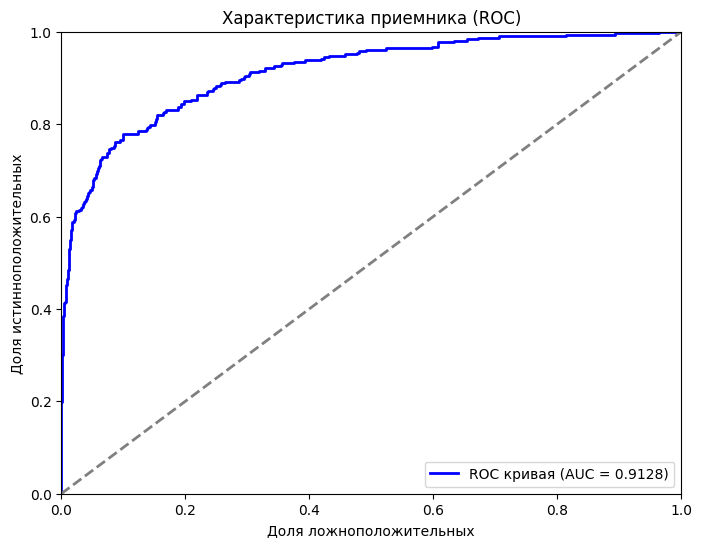

In [85]:
y_test_numeric = np.where(y_test == 'Yes', 1, 0)
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_test_cat)
roc_auc = roc_auc_score(y_test_numeric, y_test_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Доля ложноположительных')
plt.ylabel('Доля истинноположительных')
plt.title('Характеристика приемника (ROC)')
plt.legend(loc='lower right')
plt.show()

Модель хорошо различает положительные и отрицательные примеры. Она имеет высокую чувствительность и низкую долю ложноположительных предсказаний.

In [92]:
best_model_cat = grid_search_cat.best_estimator_
preprocessor = best_model_cat.named_steps['preprocessor']
model = best_model_cat.named_steps['model']

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out()
num_feature_names = num_columns
all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

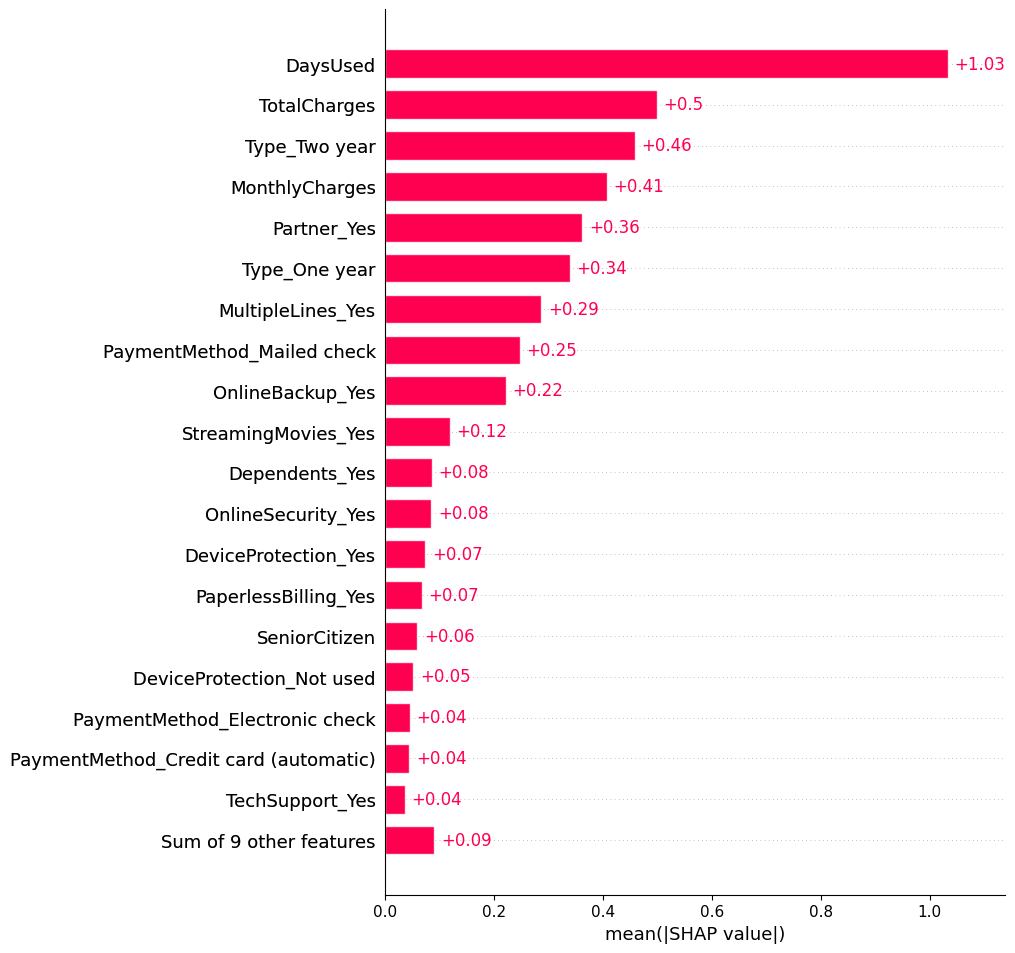

In [93]:
explainer = shap.Explainer(model, X_train_transformed_df)
shap_values = explainer(X_test_transformed_df)

shap.plots.bar(shap_values, max_display=20)

**Вывод**:
*   Признак daysused и TotalCharges сильно влияет на результат модели. Если этот признак увеличивается, это значительно повышает вероятность оттока клиентов.
*  Признак type_two year оказывает умеренное положительное влияние на прогнозируемый результат модели. Этот признак также способствует увеличению вероятности оттока, хотя и в меньшей степени, чем daysused.
* Большенство признаков, которые так или иначе не оказывают влияния на модель находятся в таблице personal или internet.


## Общий вывод

**Цель проекта**
Целью данного проекта было создание модели для прогнозирования оттока клиентов для оператора связи «ТелеДом». Проект включал несколько ключевых задач: анализ и подготовка данных, обучение и тестирование моделей машинного обучения, а также выбор лучшей модели для прогноза.

**Основные задачи и результаты**

1. Анализ и подготовка данных
   - Загрузка данных и первичный анализ: На начальном этапе были загружены данные из нескольких источников, и выполнен первичный анализ. Были выявлены ключевые характеристики данных и возможные проблемы, такие как пустые строки и дисбаланс классов.

3. Исследовательский анализ данных
   - Создание новых признаков: Были созданы новые признаки, такие как количество дней использования услуг, чтобы улучшить качество модели. Эти признаки включали как количество дней, так и категориальные признаки с учетом отсутствующих данных.
   - Анализ корреляций: Выявлено, что многие признаки имеют высокую корреляцию между собой, что может привести к проблемам мультиколлинеарности. Корреляция целевого признака с другими признаками была относительно низкой, но признак "Дни использования" показал наибольшую корреляцию с целевым признаком.
   - Исследовательский анализ данных выявил важные аспекты, которые оказали влияние на моделирование. Визуализации распределений и анализа категориальных признаков подтвердили наличие дисбаланса классов и необходимость его учета при построении моделей.

2. Объединение данных
   - Объединение данных в общую таблицу: Данные из различных источников были объединены в единую таблицу, что позволило получить целостное представление о клиентских данных. Образовавшиеся прпопуски были заменены на значение 'Not used', что указывает на отсутствие использования соответствующих услуг.

4. Подготовка данных для обучения
   - Предобработка данных: Были использованы различные методы предобработки, включая кодирование категориальных признаков, масштабирование числовых признаков и обработку пропусков.

5. Обучение моделей
   - Выбор моделей и гиперпараметров: Были протестированы несколько моделей машинного обучения, включая логистическую регрессию, случайный лес, CatBoost и LightGBM. Для каждой модели был проведен GridSearchCV для выбора лучших гиперпараметров.
   - Учет дисбаланса классов: В моделях была учтена проблема дисбаланса классов с помощью соответствующих параметров.

6. Выбор лучшей модели и тестирование
   - Оценка моделей: Лучшая модель CatBoostClassifier. Модель продемонстрировала отличные результаты как на кросс-валидации, так и на валидационной и тестовой выборках.
   - Результаты для CatBoostClassifier:
     - Лучшие параметры: {'model__depth': 4, 'model__iterations': 200, 'model__learning_rate': 0.2, 'preprocessor__num': 'passthrough'}
     - Лучший ROC AUC на кросс-валидации: 0.8987
     - ROC AUC на тестовой выборке: 0.9128
     - Кривая ROC AUC показала, что модель хорошо различает положительные и отрицательные примеры. Она имеет высокую чувствительность и низкую долю ложноположительных предсказаний.
**Рекомендации**
- Анализ потребностей клиентов: Поскольку наблюдается сокращение доходов с увеличением числа новых договоров. Возможно, потребуется пересмотреть ценообразование или предложить более привлекательные тарифные опции, чтобы увеличить прибыль и удержание клиентов.
- Внедрение гибких тарифов: Рассмотреть возможность внедрения более гибких тарифных планов, которые лучше соответствуют потребностям различных клиентов, что может повысить удовлетворенность и удержание.
- Упростить процесс подключения и управления дополнительными услугами, чтобы сделать их более доступными и привлекательными для клиентов.
- Разработать и внедрить программы лояльности, которые поощряют долгосрочное сотрудничество и увеличение потребления услуг.
- Развитие новых услуг.